In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv(r'C:\Users\jeanv\Documents\GitHub\jun24_bc_llm\df_all_summaries_rouge-llm_eval_elagage.csv')

# Assuming the Dale-Chall scale goes from 0 to 10
#df['dale_chall_readability_reversed'] = 12 - df['dale_chall_readability']

df = df.rename(columns={'Bert_Score': 'bert_score', 'cosine_sim_ref': 'l6_cosine', 'Accuracy_ref_llm': 'accuracy_ref', 
                        'Conciseness_ref_llm': 'conciseness_ref', 'Structure_ref_llm': 'structure_ref', 'refBased_llm_mean_score': 'ref_based_mean', 
                        'Accuracy_llm': 'accuracy_free', 'Clarity_llm': 'clarity_free' ,'Coverage_llm': 'coverage_free', 'Overall_llm': 'quality_free',
                        'flesch_reading_ease': 'flesch_reading', 'dale_chall_readability':'dale_chall', 'refFree_llm_mean_score': 'ref_free_mean'}) 

# drop sampling
df = df.drop(['sampling'], axis = 1)

# Extract 'random' and 'preclassified' from 'type'
df['sampling'] = df['type'].apply(lambda x: 'random' if x.startswith('R_') else 'pre-classified' if x.startswith('PC_') else None)

# Remove 'R_' and 'PC_' prefixes from the 'type' column
df['type'] = df['type'].str.replace(r'R_|PC_', '', regex=True)

df = df.rename(columns={'type':'text_type'})

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']


# Calculate mean for each dependent variable grouped by 'model_name'
df_viz = df.groupby('model_name')[dependent_vars].mean().round(2).reset_index()

df_viz.to_csv('table_LLM_meanscores.csv')

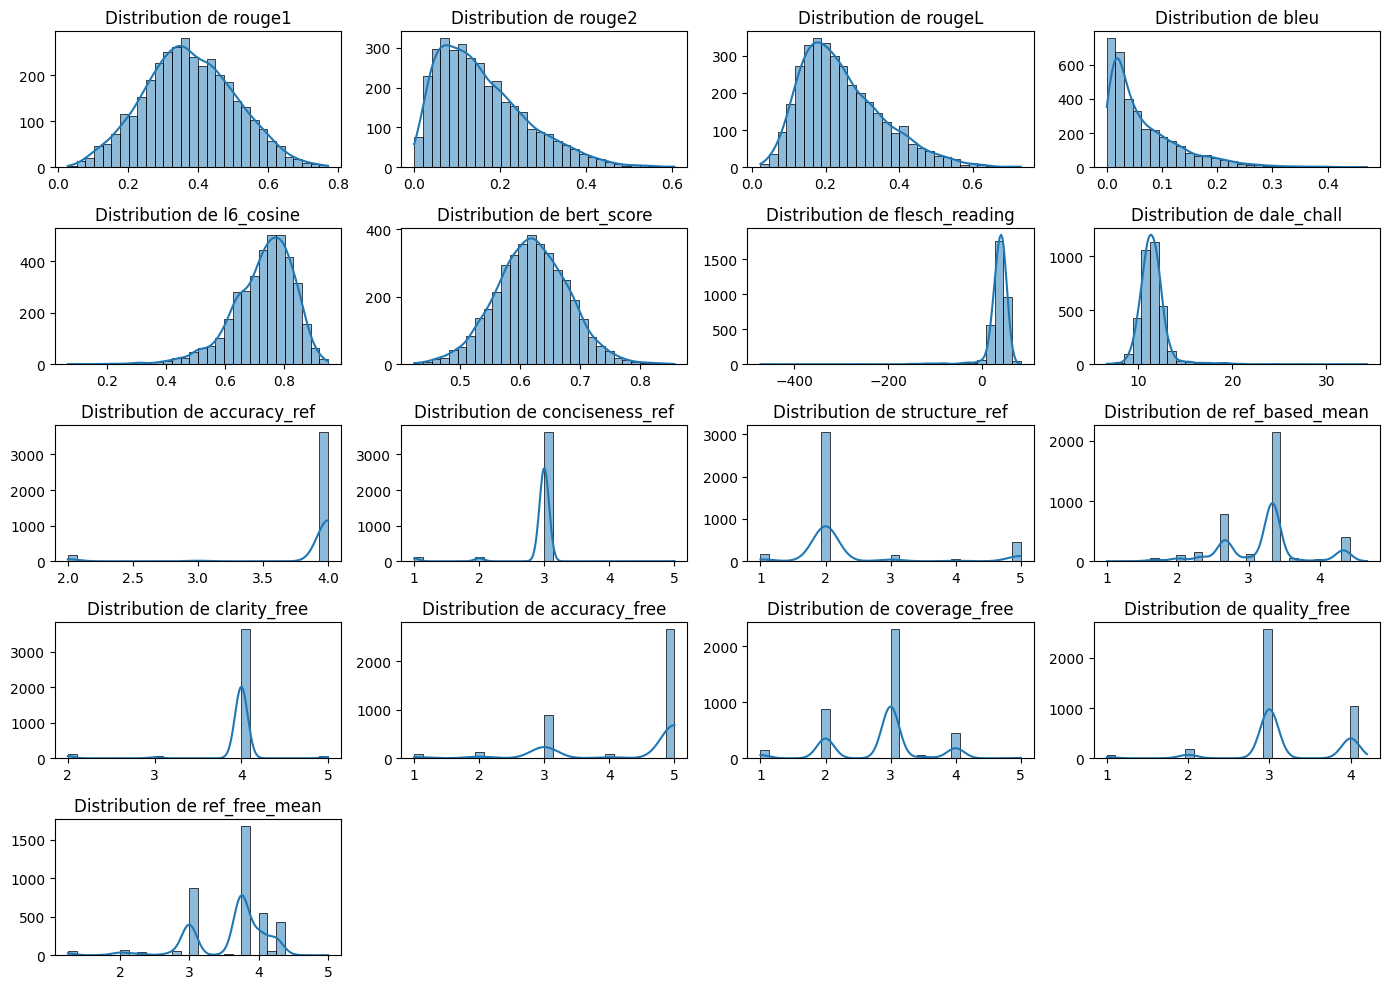

In [5]:
independent_vars = ['sampling', 'text_type', 'model_name', 'prompt_type']

dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'l6_cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']

plt.figure(figsize=(14, 10))
for i, var in enumerate(dependent_vars):
    plt.subplot(5, 4, i + 1)  # Ajuster le nombre de lignes et de colonnes en fonction du nombre de variables
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribution de {var}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()

In [13]:
dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'l6_cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']

# Normalize
scaler = StandardScaler()
df[dependent_vars] = scaler.fit_transform(df[dependent_vars])

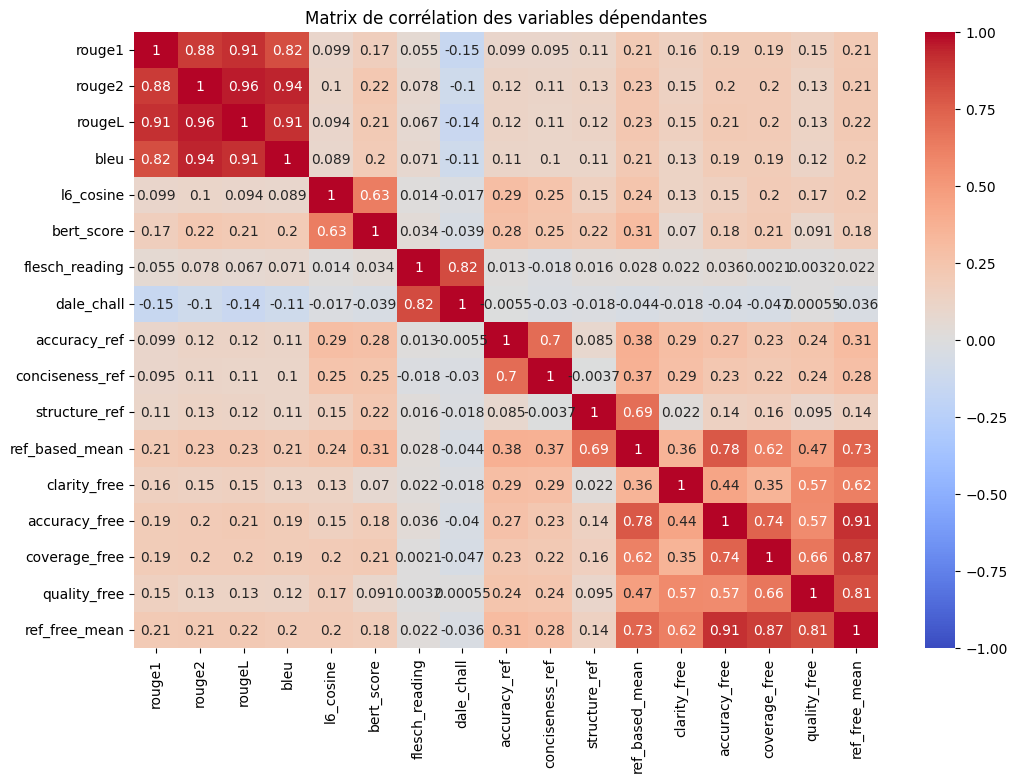

In [14]:
# Correlation matrix of dependent variables
corr_matrix = df[dependent_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrix de corrélation des variables dépendantes')
plt.show()

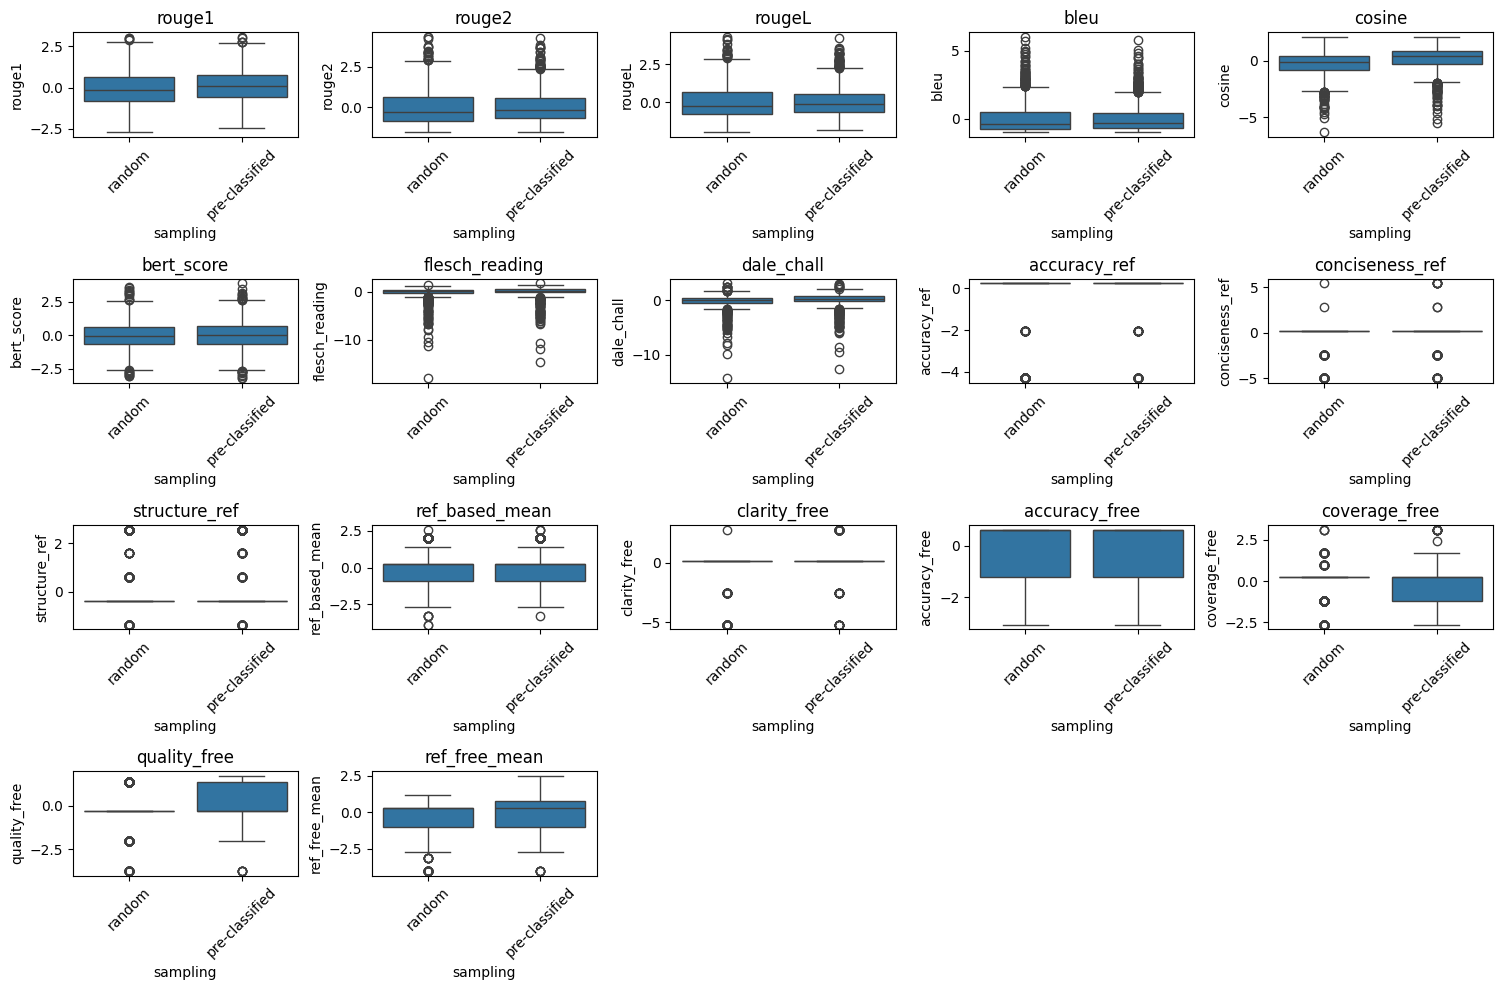

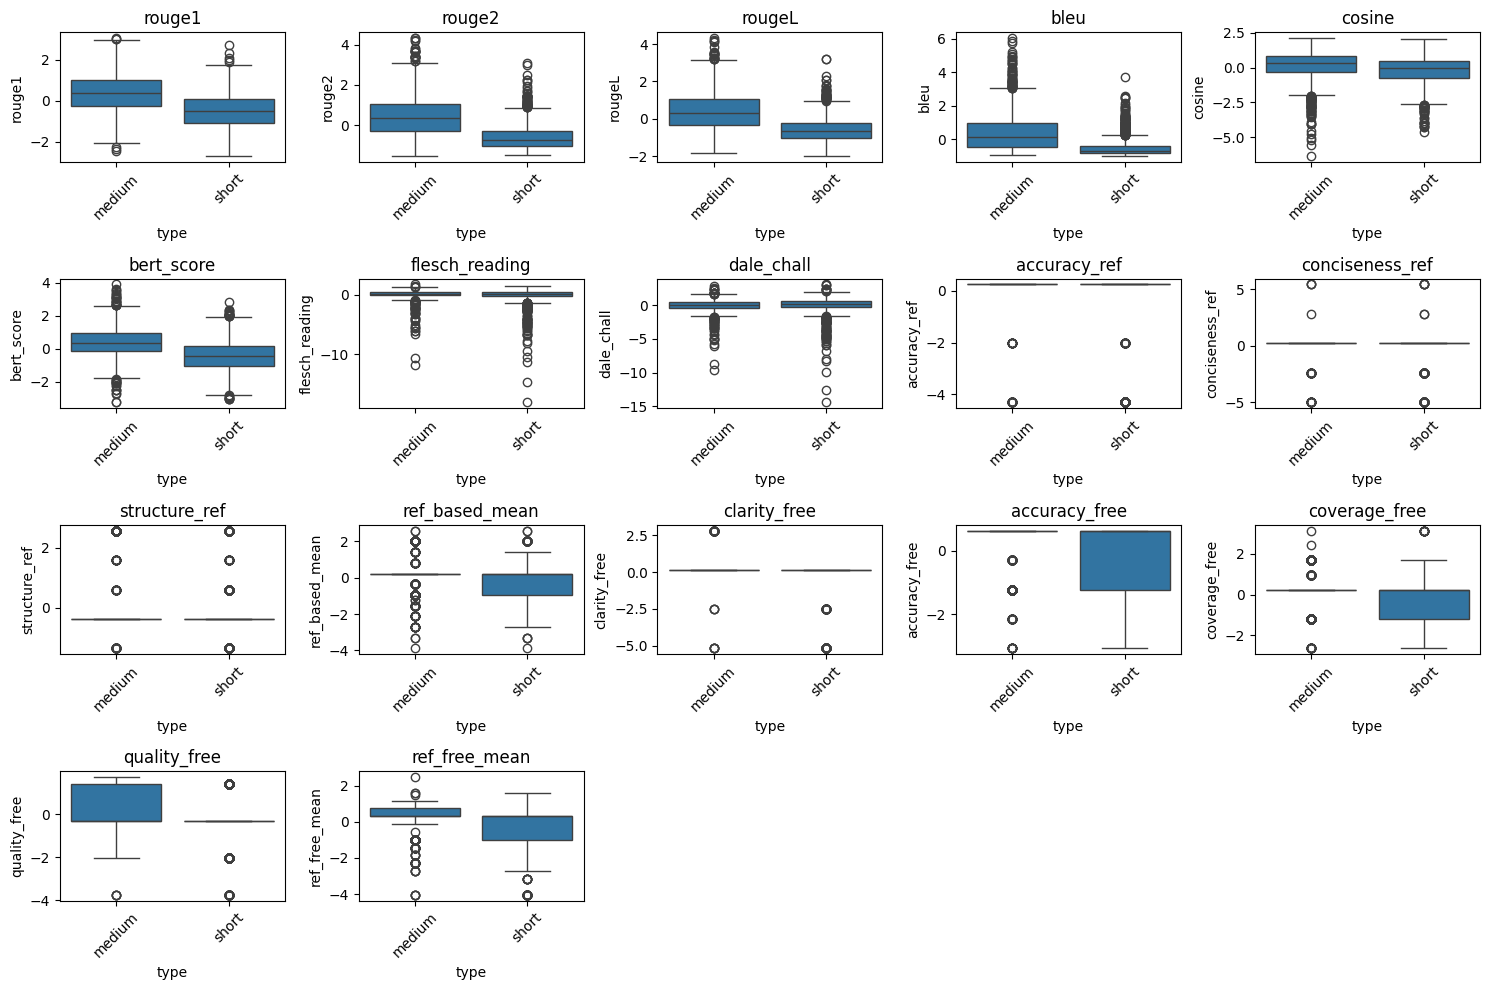

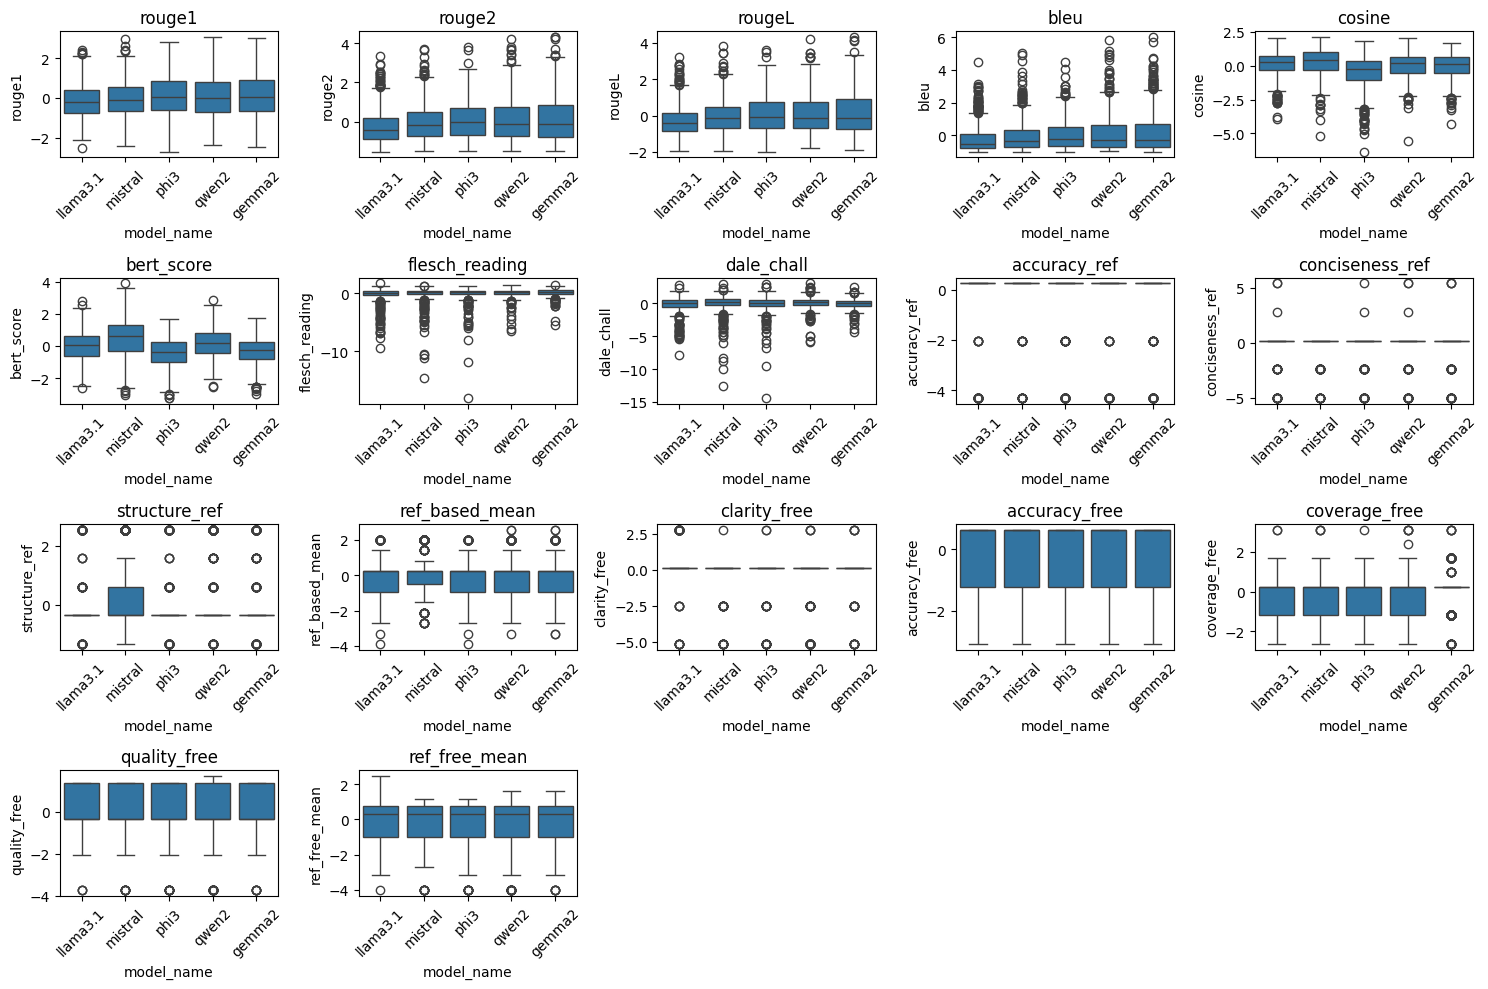

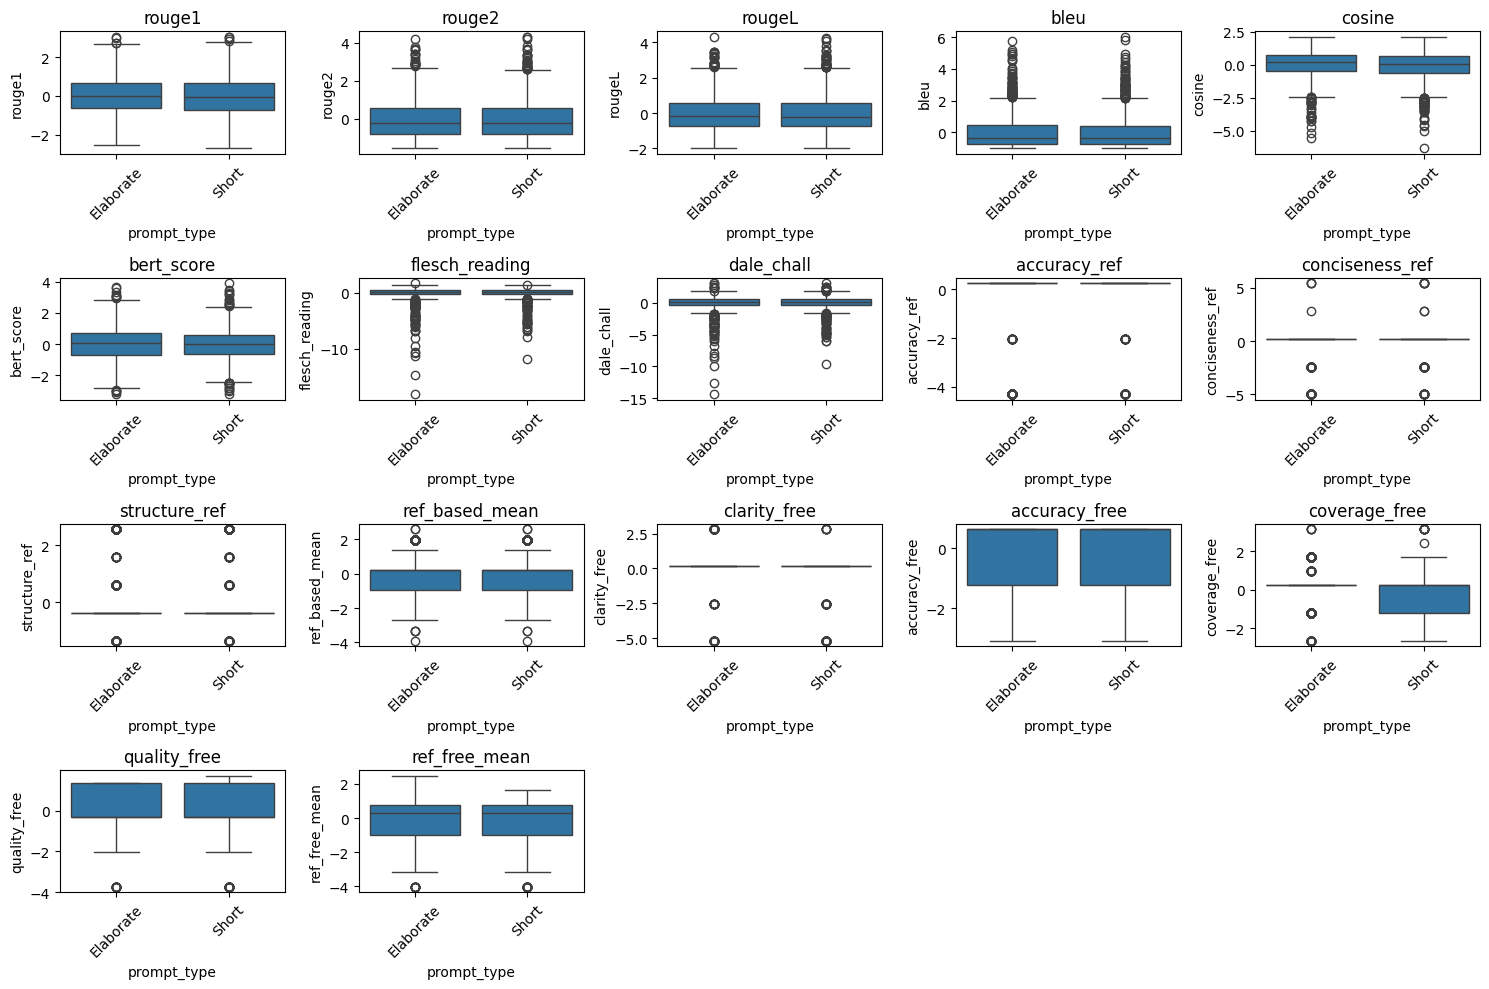

In [44]:
independent_vars = ['sampling', 'text_type', 'model_name', 'prompt_type']

for indep_var in independent_vars:
    plt.figure(figsize=(15, 10))
    for i, dep_var in enumerate(dependent_vars):
        plt.subplot(4, 5, i + 1)  # Adjust grid size based on number of dependent variables
        sns.boxplot(x=indep_var, y=dep_var, data=df)
        plt.title(f'{dep_var}')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

Normality testing

In [13]:
independent_vars = ['sampling', 'text_type', 'model_name', 'prompt_type']

dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']

from scipy.stats import shapiro

# Create a dictionary to store the results
normality_results = {}

# Loop over all unique combinations of independent variables
for type_val in df['type'].unique():
    for prompt_val in df['prompt_type'].unique():
        for model_val in df['model_name'].unique():
            for sampling_val in df['sampling'].unique():
                
                # Create a key for this combination of independent variables
                key = (type_val, prompt_val, model_val, sampling_val)
                normality_results[key] = {}
                
                # Filter the dataframe for the current combination of independent variables
                df_filtered = df[(df['type'] == type_val) &
                                 (df['prompt_type'] == prompt_val) &
                                 (df['model_name'] == model_val) &
                                 (df['sampling'] == sampling_val)]
                
                # Test normality for each dependent variable
                for var in dependent_vars:
                    if len(df_filtered[var].dropna()) > 2:  # Shapiro requires at least 3 data points
                        stat, p_value = shapiro(df_filtered[var].dropna())
                        normality_results[key][var] = p_value
                    else:
                        normality_results[key][var] = None  # Not enough data to perform test

# Convert results to a multi-index dataframe for easier viewing
normality_df = pd.DataFrame(normality_results).T  # .T transposes the DataFrame

normality_df_classified = normality_df.applymap(lambda x: 'insufficient data' if x is None 
                                                else 'normal' if x >= 0.05 
                                                else 'pas normal')

# Display the classified dataframe
print(normality_df)

total_cells = normality_df_classified.size
pas_normal_count = (normality_df_classified == 'pas normal').sum().sum()

# Calculate the percentage
pas_normal_percentage = (pas_normal_count / total_cells) * 100

# Print the percentage
#print(f"Percentage of 'pas normal': {pas_normal_percentage:.2f}%")

c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


                                            rouge1        rouge2  \
medium Elaborate llama3.1 random          0.247061  1.206428e-05   
                          pre-classified  0.603603  1.071970e-03   
                 mistral  random          0.350739  2.837468e-04   
                          pre-classified  0.517860  5.195132e-05   
                 phi3     random          0.005277  5.096645e-01   
                          pre-classified  0.492990  4.767743e-04   
                 qwen2    random          0.010483  9.696946e-01   
                          pre-classified  0.080888  1.697977e-06   
                 gemma2   random          0.052535  3.834634e-04   
                          pre-classified  0.091484  1.321241e-01   
       Short     llama3.1 random          0.961857  8.904213e-04   
                          pre-classified  0.348276  1.050732e-03   
                 mistral  random          0.007967  1.107837e-04   
                          pre-classified  0.3485

C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\2150621237.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  normality_df_classified = normality_df.applymap(lambda x: 'insufficient data' if x is None


Normality testing (plot Rouge and Bertscore in terms of all combinations)

In [18]:
''''import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Generate all combinations of independent variables
combinations = list(itertools.product(df['sampling'].unique(), df['text_type'].unique(), df['model_name'].unique(), df['prompt_type'].unique()))

# Create a figure with subplots for 'bert_score' histograms
fig, axes = plt.subplots(len(combinations), 2, figsize=(10, len(combinations) * 4))
fig.suptitle('Histograms for BERT Score and ROUGE1', fontsize=16)

# Plot histograms for 'bert_score' and 'rouge1'
for idx, combo in enumerate(combinations):
    subset = df[(df['sampling'] == combo[0]) & (df['type'] == combo[1]) & (df['model_name'] == combo[2]) & (df['prompt_type'] == combo[3])]
    
    # BERT Score histogram
    sns.histplot(subset['bert_score'], kde=True, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'BERT Score for {combo}')
    
    # ROUGE1 histogram
    sns.histplot(subset['rouge1'], kde=True, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'ROUGE1 for {combo}')

#plt.tight_layout()
#plt.show()'''

"'import seaborn as sns\nimport matplotlib.pyplot as plt\nimport itertools\n\n# Generate all combinations of independent variables\ncombinations = list(itertools.product(df['sampling'].unique(), df['text_type'].unique(), df['model_name'].unique(), df['prompt_type'].unique()))\n\n# Create a figure with subplots for 'bert_score' histograms\nfig, axes = plt.subplots(len(combinations), 2, figsize=(10, len(combinations) * 4))\nfig.suptitle('Histograms for BERT Score and ROUGE1', fontsize=16)\n\n# Plot histograms for 'bert_score' and 'rouge1'\nfor idx, combo in enumerate(combinations):\n    subset = df[(df['sampling'] == combo[0]) & (df['type'] == combo[1]) & (df['model_name'] == combo[2]) & (df['prompt_type'] == combo[3])]\n    \n    # BERT Score histogram\n    sns.histplot(subset['bert_score'], kde=True, ax=axes[idx, 0])\n    axes[idx, 0].set_title(f'BERT Score for {combo}')\n    \n    # ROUGE1 histogram\n    sns.histplot(subset['rouge1'], kde=True, ax=axes[idx, 1])\n    axes[idx, 1].set_t

Testing of equal variance

In [63]:
from scipy import stats

def perform_levene_test(df, independent_vars, dependent_vars):
    for dep_var in dependent_vars:
        # Group data by independent variables
        grouped_data = [group[dep_var].dropna().values for name, group in df.groupby(independent_vars)]
        
        # Perform Levene's test
        if len(grouped_data) > 1:  # Ensure there is more than one group
            statistic, p_value = stats.levene(*grouped_data, center='median')
            
            print(f"\nLevene's test for {dep_var}:")
            print(f"Statistic: {statistic}")
            print(f"P-value: {p_value}")
            
            if p_value < 0.05:
                print("The assumption of equal variances is violated.")
            else:
                print("The assumption of equal variances is not violated.")
        else:
            print(f"\nNot enough groups to perform Levene's test for {dep_var}.")

# Perform the test
perform_levene_test(df, independent_vars, dependent_vars)


Levene's test for rouge1:
Statistic: 5.200938337227908
P-value: 3.4718867123780584e-23
The assumption of equal variances is violated.

Levene's test for rouge2:
Statistic: 9.985246707543174
P-value: 1.0142974084639492e-55
The assumption of equal variances is violated.

Levene's test for rougeL:
Statistic: 7.799918756955718
P-value: 1.0893796717149107e-40
The assumption of equal variances is violated.

Levene's test for bleu:
Statistic: 14.629762951256309
P-value: 1.3820990458667178e-87
The assumption of equal variances is violated.

Levene's test for cosine:
Statistic: 4.279246805612734
P-value: 2.7258836050064625e-17
The assumption of equal variances is violated.

Levene's test for bert_score:
Statistic: 10.05910847578375
P-value: 1.4704868360387546e-56
The assumption of equal variances is violated.

Levene's test for flesch_reading:
Statistic: 5.641643859608092
P-value: 4.282599288911767e-26
The assumption of equal variances is violated.

Levene's test for dale_chall:
Statistic: 5.1

Variance testing (Plot Bertscore and Rouge as boxplot in terms of all combinations)

In [19]:
'''

# Create a figure with subplots for 'bert_score' and 'rouge1' boxplots
fig, axes = plt.subplots(len(combinations), 2, figsize=(10, len(combinations) * 4))
fig.suptitle('Boxplots for BERT Score and ROUGE1', fontsize=16)

# Plot boxplots for 'bert_score' and 'rouge1'
for idx, combo in enumerate(combinations):
    subset = df[(df['sampling'] == combo[0]) & (df['type'] == combo[1]) & (df['model_name'] == combo[2]) & (df['prompt_type'] == combo[3])]
    
    # BERT Score boxplot
    sns.boxplot(x='sampling', y='bert_score', data=subset, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'BERT Score for {combo}')
    
    # ROUGE1 boxplot
    sns.boxplot(x='sampling', y='rouge1', data=subset, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'ROUGE1 for {combo}')

plt.tight_layout()
plt.show()

'''

"\n\n# Create a figure with subplots for 'bert_score' and 'rouge1' boxplots\nfig, axes = plt.subplots(len(combinations), 2, figsize=(10, len(combinations) * 4))\nfig.suptitle('Boxplots for BERT Score and ROUGE1', fontsize=16)\n\n# Plot boxplots for 'bert_score' and 'rouge1'\nfor idx, combo in enumerate(combinations):\n    subset = df[(df['sampling'] == combo[0]) & (df['type'] == combo[1]) & (df['model_name'] == combo[2]) & (df['prompt_type'] == combo[3])]\n    \n    # BERT Score boxplot\n    sns.boxplot(x='sampling', y='bert_score', data=subset, ax=axes[idx, 0])\n    axes[idx, 0].set_title(f'BERT Score for {combo}')\n    \n    # ROUGE1 boxplot\n    sns.boxplot(x='sampling', y='rouge1', data=subset, ax=axes[idx, 1])\n    axes[idx, 1].set_title(f'ROUGE1 for {combo}')\n\nplt.tight_layout()\nplt.show()\n\n"

4-way ANOVA for ROUGE1 and BERTSCORE

In [54]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA for 'bert_score'
model_bert = ols('bert_score ~ sampling * text_type * model_name * prompt_type', data=df).fit()
anova_table_bert = sm.stats.anova_lm(model_bert, typ=2)
print("4-way ANOVA for BERT Score:\n", anova_table_bert)

# ANOVA for 'rouge1'
model_rouge = ols('rouge1 ~ sampling * text_type * model_name * prompt_type', data=df).fit()
anova_table_rouge = sm.stats.anova_lm(model_rouge, typ=2)
print("4-way ANOVA for ROUGE1 Score:\n", anova_table_rouge)

4-way ANOVA for BERT Score:
                                              sum_sq      df           F  \
sampling                                   0.022113     1.0    9.253504   
text_type                                  2.280318     1.0  954.234722   
model_name                                 1.765555     4.0  184.706037   
prompt_type                                0.001209     1.0    0.506008   
sampling:text_type                         0.064137     1.0   26.838940   
sampling:model_name                        0.011229     4.0    1.174725   
text_type:model_name                       0.198477     4.0   20.763902   
sampling:prompt_type                       0.000761     1.0    0.318580   
text_type:prompt_type                      0.723083     1.0  302.585324   
model_name:prompt_type                     0.174402     4.0   18.245280   
sampling:text_type:model_name              0.031997     4.0    3.347441   
sampling:text_type:prompt_type             0.054945     1.0   22.992627

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
  gemma2_Elaborate       gemma2_Short   0.0008    1.0  -0.012  0.0137  False
  gemma2_Elaborate llama3.1_Elaborate   0.0197 0.0001  0.0069  0.0325   True
  gemma2_Elaborate     llama3.1_Short   0.0183 0.0003  0.0055  0.0311   True
  gemma2_Elaborate  mistral_Elaborate    0.056    0.0  0.0432  0.0689   True
  gemma2_Elaborate      mistral_Short   0.0445    0.0  0.0317  0.0573   True
  gemma2_Elaborate     phi3_Elaborate   0.0013    1.0 -0.0124  0.0149  False
  gemma2_Elaborate         phi3_Short  -0.0125 0.0722 -0.0254  0.0005  False
  gemma2_Elaborate    qwen2_Elaborate   0.0183 0.0003  0.0055  0.0311   True
  gemma2_Elaborate        qwen2_Short   0.0452    0.0  0.0324   0.058   True
      gemma2_Short llama3.1_Elaborate   0.0188 0.0002   0.006  0.0317   True

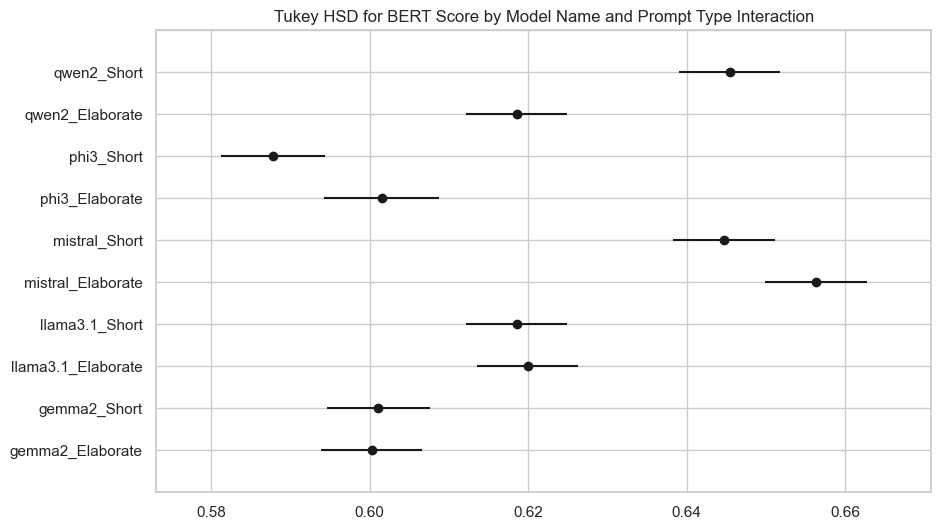

In [156]:
import statsmodels.stats.multicomp as mc

# Create interaction term as a combined factor
X = df['model_name'].astype(str) + '_' + df['prompt_type'].astype(str)

# Perform Tukey HSD on the interaction term
tukey_interaction = mc.pairwise_tukeyhsd(df['bert_score'], X)
print(tukey_interaction)

# Plot the Tukey results
tukey_interaction.plot_simultaneous()
plt.title('Tukey HSD for BERT Score by Model Name and Prompt Type Interaction')
plt.show()

In [ ]:
# Create interaction term as a combined factor
df['model_prompt_interaction'] = df['model_name'].astype(str) + '_' + df['prompt_type'].astype(str)

# Perform Tukey HSD on the interaction term
tukey_interaction = mc.pairwise_tukeyhsd(df['bert_score'], df['model_prompt_interaction'])
print(tukey_interaction)

# Plot the Tukey results
tukey_interaction.plot_simultaneous()
plt.title('Tukey HSD for BERT Score by Model Name and Prompt Type Interaction')
plt.show()

Model_name x BERTScore

C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\561003080.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model_name', y='bert_score', data=df, palette="Set2", width=0.6, linewidth=2.5)


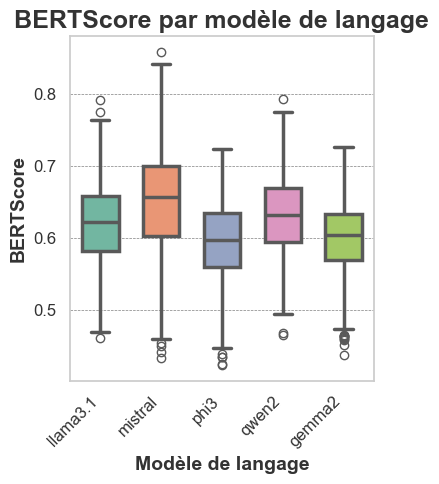

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid", palette="pastel")

# Create the boxplot
plt.figure(figsize=(4, 5))  # Adjust the figure size
sns.boxplot(x='model_name', y='bert_score', data=df, palette="Set2", width=0.6, linewidth=2.5)

# Add a stripplot to show individual data points
#sns.stripplot(x='model_name', y='bert_score', data=df, color='black', jitter=0.2, size=4, alpha=0.6)

# Add title and axis labels with custom font sizes
plt.title("BERTScore par modèle de langage", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Modèle de langage", fontsize=14, fontweight='bold', color='#333')
plt.ylabel("BERTScore", fontsize=14, fontweight='bold', color='#333')

# Customize tick labels
plt.xticks(fontsize=12, rotation=45, ha='right', color='#333')
plt.yticks(fontsize=12, color='#333')

# Add gridlines
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\3784404067.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='text_type', y='bert_score', data=df, palette="Set3", width=0.6, linewidth=2.5)


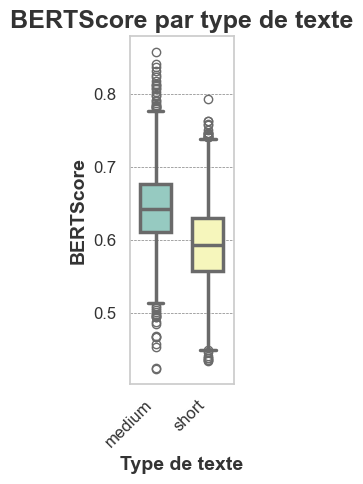

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid", palette="pastel")

# Create the boxplot
plt.figure(figsize=(2, 5))  # Adjust the figure size
sns.boxplot(x='text_type', y='bert_score', data=df, palette="Set3", width=0.6, linewidth=2.5)

# Add a stripplot to show individual data points
#sns.stripplot(x='text_type', y='bert_score', data=df, color='black', jitter=0.2, size=4, alpha=0.6)

# Add title and axis labels with custom font sizes
plt.title("BERTScore par type de texte", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Type de texte", fontsize=14, fontweight='bold', color='#333')
plt.ylabel("BERTScore", fontsize=14, fontweight='bold', color='#333')

# Customize tick labels
plt.xticks(fontsize=12, rotation=45, ha='right', color='#333')
plt.yticks(fontsize=12, color='#333')

# Add gridlines
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

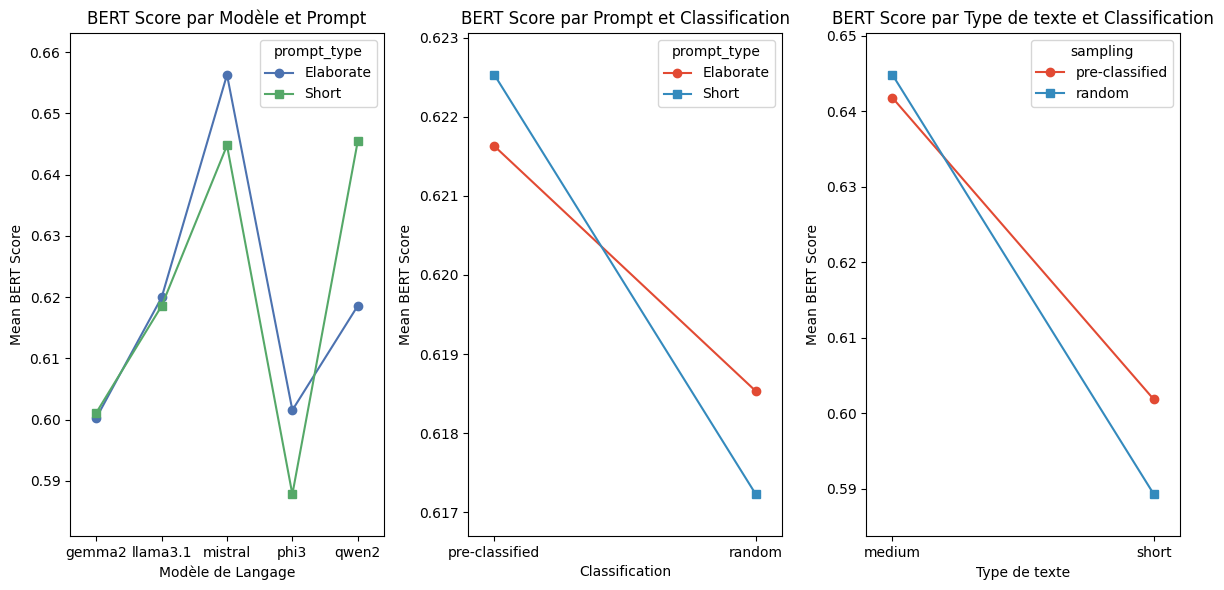

In [33]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

# Create a subplot with two figures side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Interaction plot: Model Name vs Prompt Type
interaction_plot(df['model_name'], df['prompt_type'], df['bert_score'], markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("BERT Score par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Mean BERT Score')

# Interaction plot: Model Name vs Text Type
interaction_plot(df['sampling'], df['prompt_type'], df['bert_score'], markers=['o', 's'], colors=['#e24a33', '#348abd'], ax=axes[1])
axes[1].set_title("BERT Score par Prompt et Classification")
axes[1].set_xlabel('Classification')
axes[1].set_ylabel('Mean BERT Score')

# Interaction plot: Model Name vs Text Type
interaction_plot(df['text_type'], df['sampling'], df['bert_score'], markers=['o', 's'], colors=['#e24a33', '#348abd'], ax=axes[2])
axes[2].set_title("BERT Score par Type de texte et Classification")
axes[2].set_xlabel('Type de texte')
axes[2].set_ylabel('Mean BERT Score')

# Adjust layout to make room for titles
plt.tight_layout()
plt.show()

c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#a1c9f4'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#a1c9f4'` for the same effect.

  func(*pl

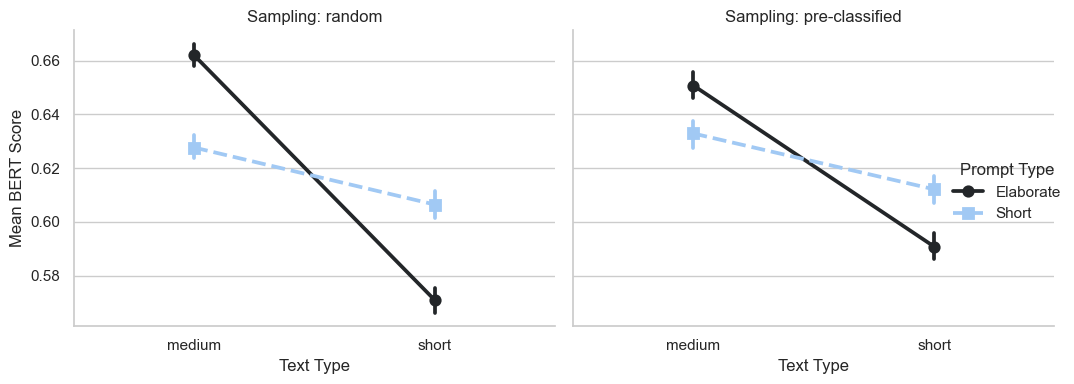

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a FacetGrid to show three-way interaction between 'text_type', 'prompt_type', and 'sampling'
g = sns.FacetGrid(df, col="sampling", height=4, aspect=1.2)

# Map a lineplot to show interaction between 'text_type' and 'prompt_type'
g.map(sns.pointplot, 'text_type', 'bert_score', 'prompt_type', markers=['o', 's'], linestyles=["-", "--"])

# Add titles and adjust layout
g.add_legend(title="Prompt Type")
g.set_axis_labels("Text Type", "Mean BERT Score")
g.set_titles(col_template="Sampling: {col_name}")
plt.tight_layout()
plt.show()

Model_name x ROUGE1

C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\65190235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model_name', y='rouge1', data=df, palette="Set2", width=0.6, linewidth=2.5)


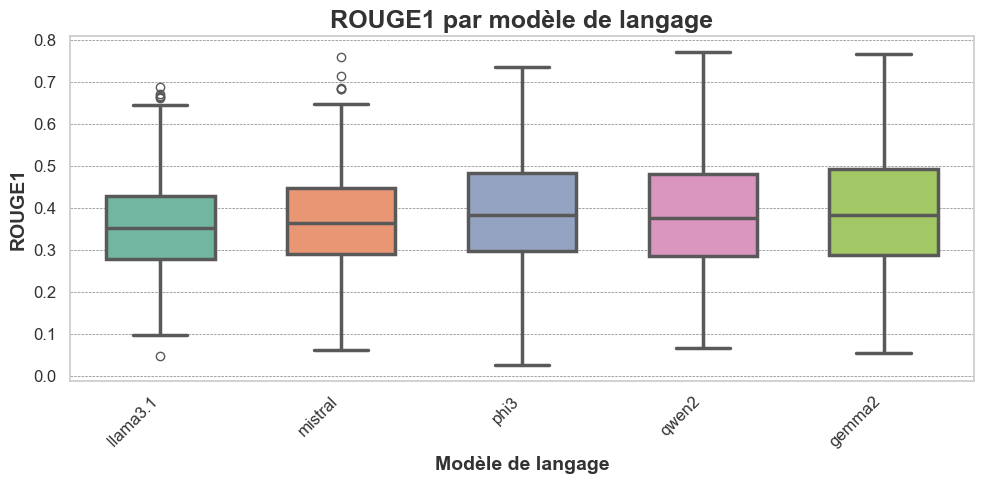

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid", palette="pastel")

# Create the boxplot
plt.figure(figsize=(10, 5))  # Adjust the figure size
sns.boxplot(x='model_name', y='rouge1', data=df, palette="Set2", width=0.6, linewidth=2.5)

# Add a stripplot to show individual data points
#sns.stripplot(x='model_name', y='bert_score', data=df, color='black', jitter=0.2, size=4, alpha=0.6)

# Add title and axis labels with custom font sizes
plt.title("ROUGE1 par modèle de langage", fontsize=18, fontweight='bold', color='#333')
plt.xlabel("Modèle de langage", fontsize=14, fontweight='bold', color='#333')
plt.ylabel("ROUGE1", fontsize=14, fontweight='bold', color='#333')

# Customize tick labels
plt.xticks(fontsize=12, rotation=45, ha='right', color='#333')
plt.yticks(fontsize=12, color='#333')

# Add gridlines
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\26561258.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sampling', y='rouge1', data=df, palette="Set3", width=0.6, linewidth=2.5, ax=axs[0])
C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\26561258.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prompt_type', y='rouge1', data=df, palette="Set3", width=0.6, linewidth=2.5, ax=axs[1])
C:\Users\jeanv\AppData\Local\Temp\ipykernel_10284\26561258.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='text_type', y='rouge1', data=d

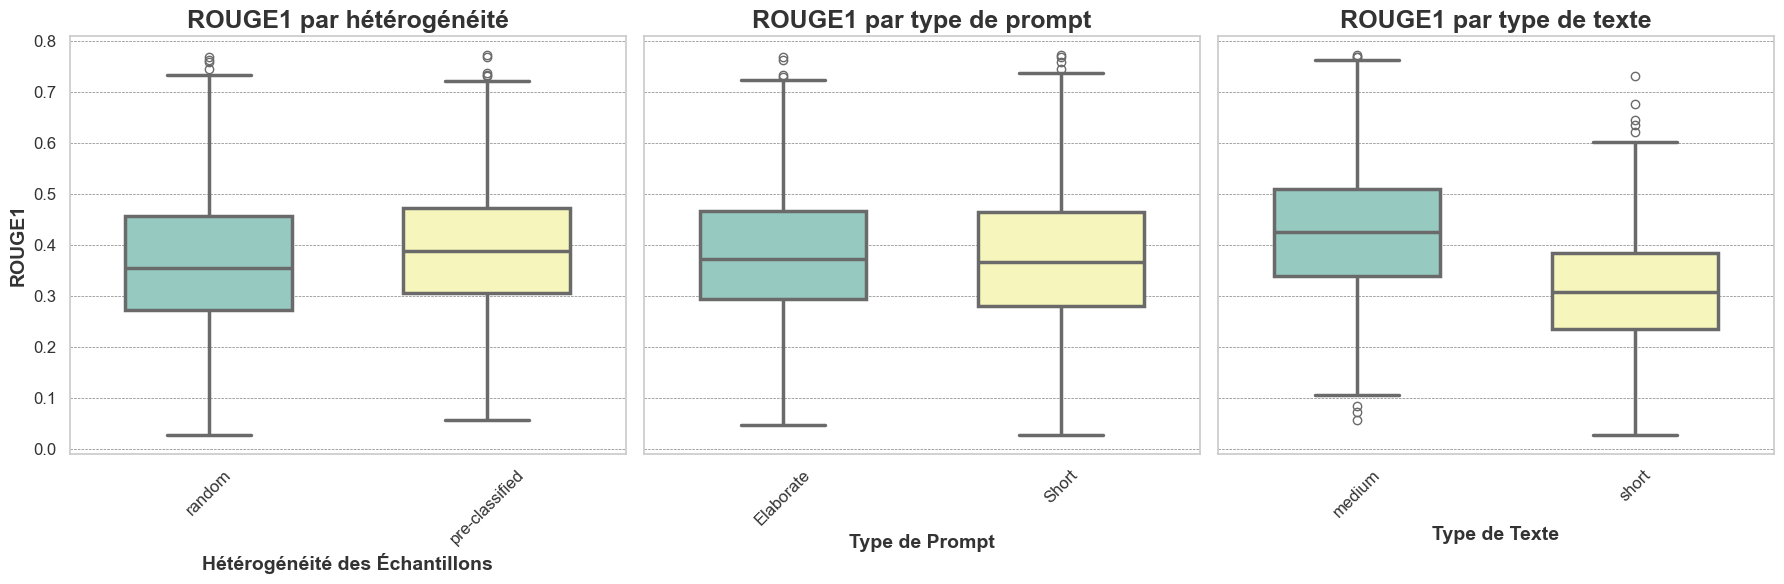

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the combined figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Boxplot for 'sampling'
sns.boxplot(x='sampling', y='rouge1', data=df, palette="Set3", width=0.6, linewidth=2.5, ax=axs[0])
axs[0].set_title("ROUGE1 par hétérogénéité", fontsize=18, fontweight='bold', color='#333')
axs[0].set_xlabel("Hétérogénéité des Échantillons", fontsize=14, fontweight='bold', color='#333')
axs[0].set_ylabel("ROUGE1", fontsize=14, fontweight='bold', color='#333')
axs[0].tick_params(axis='x', labelsize=12, labelrotation=45, labelcolor='#333')
axs[0].tick_params(axis='y', labelsize=12, labelcolor='#333')
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Boxplot for 'prompt_type'
sns.boxplot(x='prompt_type', y='rouge1', data=df, palette="Set3", width=0.6, linewidth=2.5, ax=axs[1])
axs[1].set_title("ROUGE1 par type de prompt", fontsize=18, fontweight='bold', color='#333')
axs[1].set_xlabel("Type de Prompt", fontsize=14, fontweight='bold', color='#333')
axs[1].set_ylabel("ROUGE1", fontsize=14, fontweight='bold', color='#333')
axs[1].tick_params(axis='x', labelsize=12, labelrotation=45, labelcolor='#333')
axs[1].tick_params(axis='y', labelsize=12, labelcolor='#333')
axs[1].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Boxplot for 'text_type'
sns.boxplot(x='text_type', y='rouge1', data=df, palette="Set3", width=0.6, linewidth=2.5, ax=axs[2])
axs[2].set_title("ROUGE1 par type de texte", fontsize=18, fontweight='bold', color='#333')
axs[2].set_xlabel("Type de Texte", fontsize=14, fontweight='bold', color='#333')
axs[2].set_ylabel("ROUGE1", fontsize=14, fontweight='bold', color='#333')
axs[2].tick_params(axis='x', labelsize=12, labelrotation=45, labelcolor='#333')
axs[2].tick_params(axis='y', labelsize=12, labelcolor='#333')
axs[2].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()

In [4]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD for pairwise comparisons on bert_score
tukey = pairwise_tukeyhsd(endog=df['bert_score'], groups=df['model_name'])
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  gemma2 llama3.1   0.0186    0.0  0.0107  0.0264   True
  gemma2  mistral   0.0498    0.0  0.0419  0.0577   True
  gemma2     phi3  -0.0067 0.1696 -0.0149  0.0015  False
  gemma2    qwen2   0.0313    0.0  0.0235  0.0392   True
llama3.1  mistral   0.0313    0.0  0.0234  0.0391   True
llama3.1     phi3  -0.0252    0.0 -0.0334 -0.0171   True
llama3.1    qwen2   0.0128 0.0001  0.0049  0.0206   True
 mistral     phi3  -0.0565    0.0 -0.0647 -0.0483   True
 mistral    qwen2  -0.0185    0.0 -0.0264 -0.0106   True
    phi3    qwen2    0.038    0.0  0.0299  0.0462   True
--------------------------------------------------------


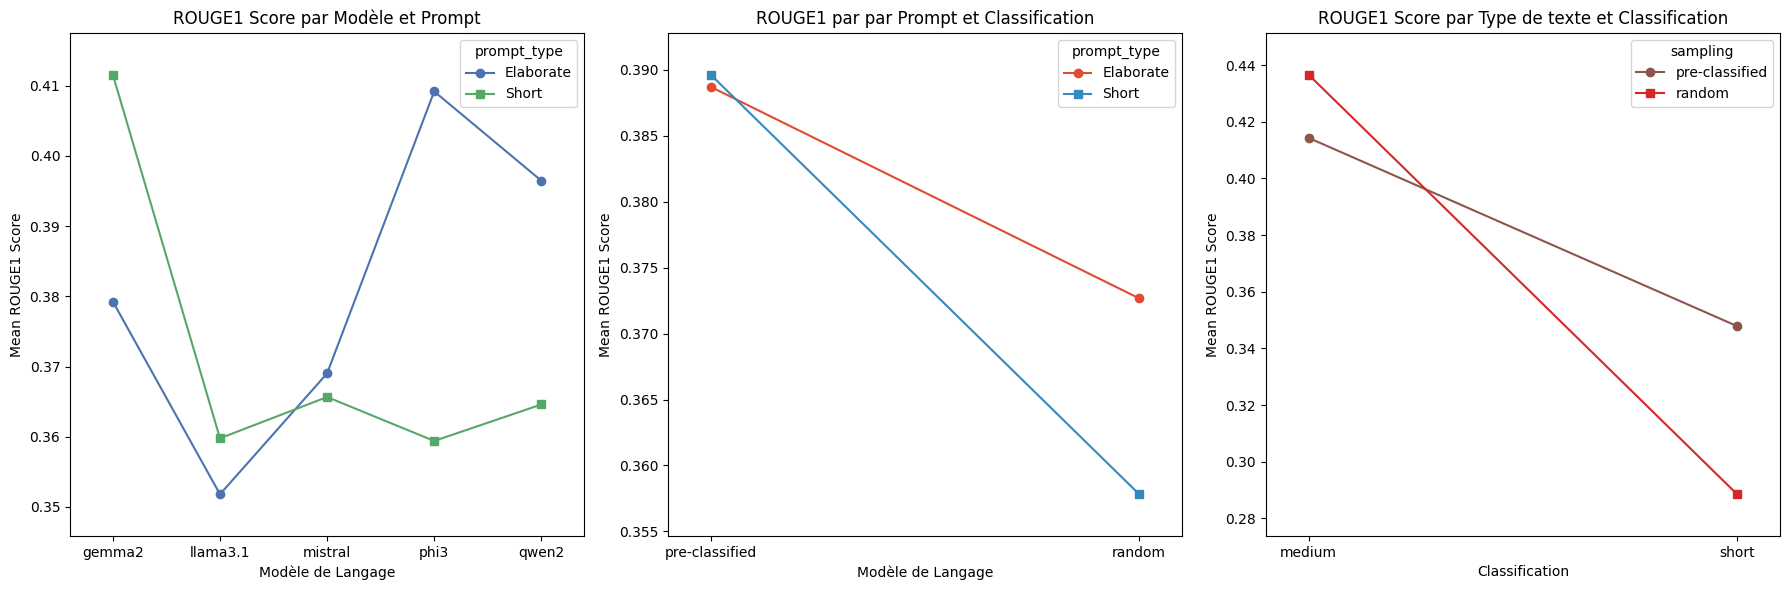

In [38]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

# Create a subplot with three figures side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Interaction plot: Model Name vs Prompt Type
interaction_plot(df['model_name'], df['prompt_type'], df['rouge1'], markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("ROUGE1 Score par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Mean ROUGE1 Score')

# Interaction plot: Model Name vs Text Type
interaction_plot(df['sampling'], df['prompt_type'], df['rouge1'], markers=['o', 's'], colors=['#e24a33', '#348abd'], ax=axes[1])
axes[1].set_title("ROUGE1 par par Prompt et Classification")
axes[1].set_xlabel('Modèle de Langage')
axes[1].set_ylabel('Mean ROUGE1 Score')

# Interaction plot: Text Type vs Prompt Type
interaction_plot(df['text_type'], df['sampling'], df['rouge1'], markers=['o', 's'], colors=['#8c564b', '#d62728'], ax=axes[2])
axes[2].set_title("ROUGE1 Score par Type de texte et Classification")
axes[2].set_xlabel('Classification')
axes[2].set_ylabel('Mean ROUGE1 Score')

# Adjust layout to make room for titles
plt.tight_layout()
plt.show()

c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#a1c9f4'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\jeanv\Documents\GitHub\jun24_bc_llm\.venv\lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#a1c9f4'` for the same effect.

  func(*pl

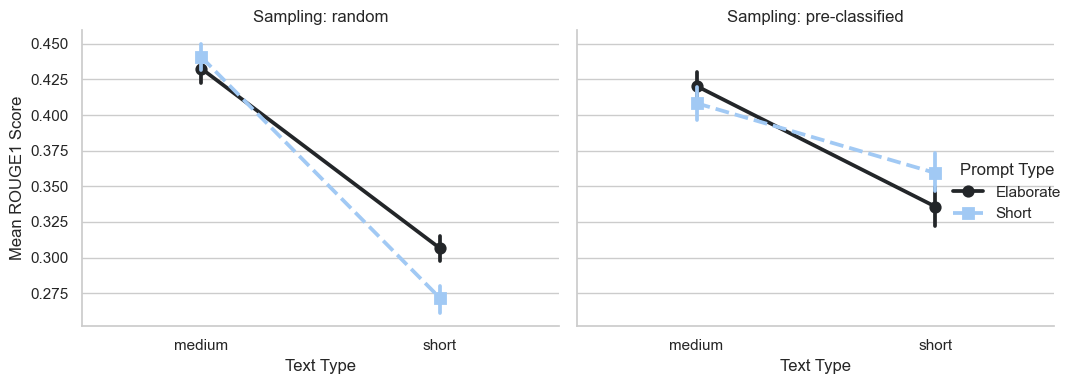

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a FacetGrid to show three-way interaction between 'text_type', 'prompt_type', and 'sampling'
g = sns.FacetGrid(df, col="sampling", height=4, aspect=1.2)

# Map a lineplot to show interaction between 'text_type' and 'prompt_type'
g.map(sns.pointplot, 'text_type', 'rouge1', 'prompt_type', markers=['o', 's'], linestyles=["-", "--"])

# Add titles and adjust layout
g.add_legend(title="Prompt Type")
g.set_axis_labels("Text Type", "Mean ROUGE1 Score")
g.set_titles(col_template="Sampling: {col_name}")
plt.tight_layout()
plt.show()

Model_Name (Kruskal-Wallis H Test)

In [87]:
from scipy.stats import kruskal

df.filtered = df[df['bleu']].dropna() 

kruskal(*[df[df['model_name'] == name]['bleu'] for name in df['model_name'].unique()])

KruskalResult(statistic=nan, pvalue=nan)

In [32]:
from scipy.stats import kruskal
import seaborn as sns
import matplotlib.pyplot as plt

dependent_vars = ['rouge2', 'rougeL', 'bleu', 'l6_cosine', 'flesch_reading', 'dale_chall', 'accuracy_ref',
                  'conciseness_ref', 'structure_ref', 'ref_based_mean', 'clarity_free', 'accuracy_free',
                  'coverage_free', 'quality_free', 'ref_free_mean']

# Kruskal-Wallis for 'model_name'
for var in dependent_vars:
    # Drop rows with NaN values for the dependent variable
    df_clean = df.dropna(subset=[var])

    # Perform the Kruskal-Wallis test
    result = kruskal(*[df_clean[df_clean['model_name'] == name][var] for name in df_clean['model_name'].unique()])
    
    # Print the result
    print(f"Kruskal-Wallis test for {var} (model_name): {result}")
    
    # If the result is significant (p-value < 0.05), plot a boxplot
    #if result.pvalue < 0.05:
    #    plt.figure(figsize=(8, 4))
    #    sns.boxplot(x='model_name', y=var, data=df_clean)
    #    plt.title(f"Significant result: {var} by model_name")
    #    plt.show()

Kruskal-Wallis test for rouge2 (model_name): KruskalResult(statistic=55.55880268198889, pvalue=2.4810815698153883e-11)
Kruskal-Wallis test for rougeL (model_name): KruskalResult(statistic=54.58722588565979, pvalue=3.96481489087698e-11)
Kruskal-Wallis test for bleu (model_name): KruskalResult(statistic=48.713022124199604, pvalue=6.701795070814309e-10)
Kruskal-Wallis test for l6_cosine (model_name): KruskalResult(statistic=239.26852208734527, pvalue=1.3334331581120363e-50)
Kruskal-Wallis test for flesch_reading (model_name): KruskalResult(statistic=44.66993598970647, pvalue=4.6564383342077486e-09)
Kruskal-Wallis test for dale_chall (model_name): KruskalResult(statistic=31.81320345879755, pvalue=2.088848608381744e-06)
Kruskal-Wallis test for accuracy_ref (model_name): KruskalResult(statistic=28.18748403361008, pvalue=1.1427797483190446e-05)
Kruskal-Wallis test for conciseness_ref (model_name): KruskalResult(statistic=12.373720593294241, pvalue=0.01477814473533951)
Kruskal-Wallis test for 

In [35]:

'''
import scikit_posthocs as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Run Dunn's test with Bonferroni correction for significant variables
for var in dependent_vars:
    df_clean = df.dropna(subset=[var])
    model_names = df_clean['model_name'].unique()
    data = [df_clean[df_clean['model_name'] == name][var].values for name in model_names]

    # Perform Dunn's test with Bonferroni correction
    dunn_result = sp.posthoc_dunn(data, p_adjust='bonferroni')

    # Print the result
    print(f"Dunn-Bonferroni post-hoc test for {var}:")
    print(dunn_result)

    # Visualize significant post-hoc results
    plt.figure(figsize=(8, 6))
    sns.heatmap(dunn_result, annot=True, cmap="coolwarm", cbar=True, linewidths=0.5, 
                xticklabels=model_names, yticklabels=model_names)
    plt.title(f"Post-hoc Dunn-Bonferroni results for {var}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    '''

'\nimport scikit_posthocs as sp\nimport numpy as np\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Run Dunn\'s test with Bonferroni correction for significant variables\nfor var in dependent_vars:\n    df_clean = df.dropna(subset=[var])\n    model_names = df_clean[\'model_name\'].unique()\n    data = [df_clean[df_clean[\'model_name\'] == name][var].values for name in model_names]\n\n    # Perform Dunn\'s test with Bonferroni correction\n    dunn_result = sp.posthoc_dunn(data, p_adjust=\'bonferroni\')\n\n    # Print the result\n    print(f"Dunn-Bonferroni post-hoc test for {var}:")\n    print(dunn_result)\n\n    # Visualize significant post-hoc results\n    plt.figure(figsize=(8, 6))\n    sns.heatmap(dunn_result, annot=True, cmap="coolwarm", cbar=True, linewidths=0.5, \n                xticklabels=model_names, yticklabels=model_names)\n    plt.title(f"Post-hoc Dunn-Bonferroni results for {var}")\n    plt.xticks(rotation=45, ha="right")\n    plt.yticks(rotation=0)\n    plt.

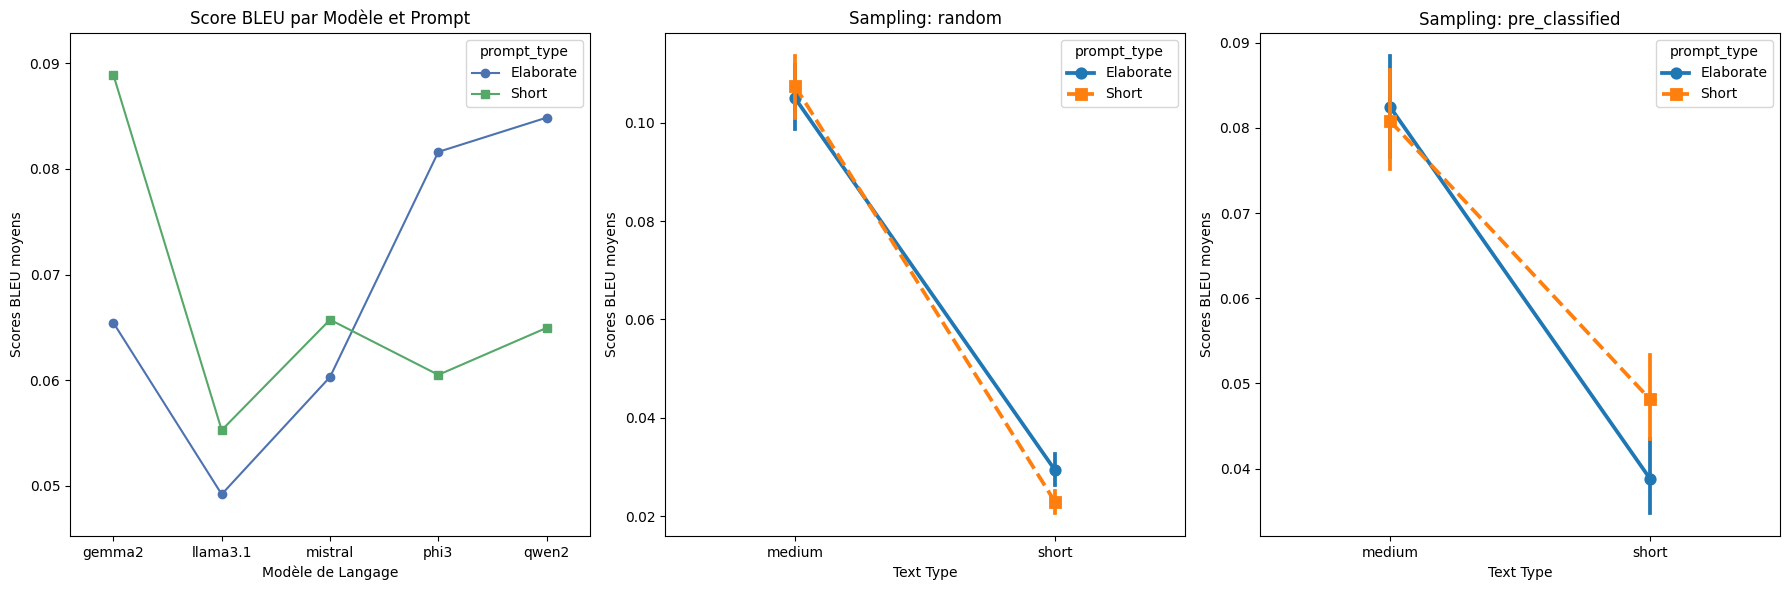

In [87]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns

# Create a subplot with three plots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Interaction plot: Model Name vs Prompt Type (1st plot)
interaction_plot(df['model_name'], df['prompt_type'], df['bleu'], 
                 markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("Score BLEU par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Scores BLEU moyens')

# 2. Facet-like plot for 'sampling' == 'random' (2nd plot)
sns.pointplot(x='text_type', y='bleu', hue='prompt_type', data=df[df['sampling'] == 'random'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[1])
axes[1].set_title("Sampling: random")
axes[1].set_xlabel('Text Type')
axes[1].set_ylabel('Scores BLEU moyens')

# 3. Facet-like plot for 'sampling' == 'fixed' (3rd plot)
sns.pointplot(x='text_type', y='bleu', hue='prompt_type', data=df[df['sampling'] == 'pre-classified'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[2])
axes[2].set_title("Sampling: pre_classified")
axes[2].set_xlabel('Text Type')
axes[2].set_ylabel('Scores BLEU moyens')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

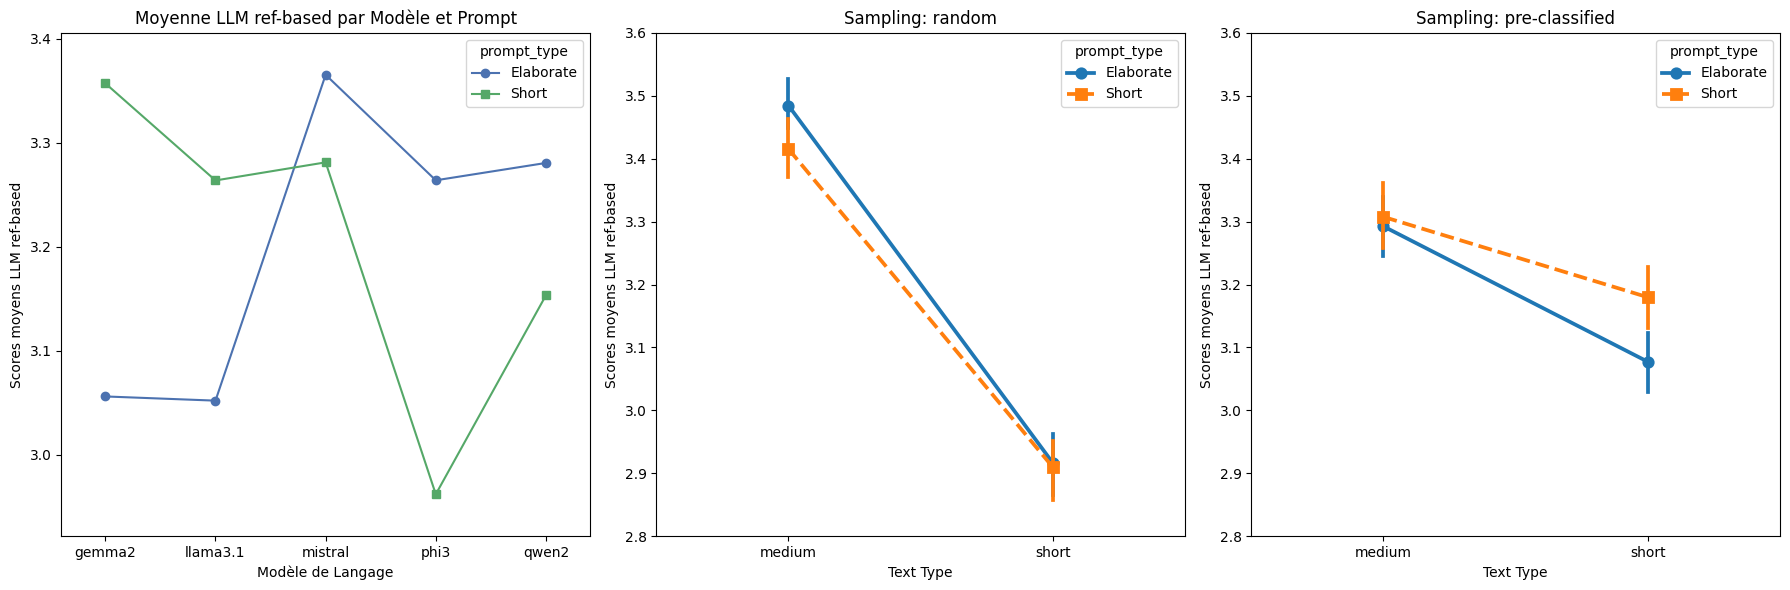

In [91]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns

# Create a subplot with three plots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Interaction plot: Model Name vs Prompt Type (1st plot)
interaction_plot(df['model_name'], df['prompt_type'], df['ref_based_mean'], 
                 markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("Moyenne LLM ref-based par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Scores moyens LLM ref-based')

# 2. Facet-like plot for 'sampling' == 'random' (2nd plot)
sns.pointplot(x='text_type', y='ref_based_mean', hue='prompt_type', data=df[df['sampling'] == 'random'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[1])
axes[1].set_title("Sampling: random")
axes[1].set_xlabel('Text Type')
axes[1].set_ylabel('Scores moyens LLM ref-based')

# 3. Facet-like plot for 'sampling' == 'fixed' (3rd plot)
sns.pointplot(x='text_type', y='ref_based_mean', hue='prompt_type', data=df[df['sampling'] == 'pre-classified'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[2])
axes[2].set_title("Sampling: pre-classified")
axes[2].set_xlabel('Text Type')
axes[2].set_ylabel('Scores moyens LLM ref-based')

# Set the same y-axis limits for both the center and right plots
y_min = 2.8
y_max = 3.6
axes[1].set_ylim(y_min, y_max)
axes[2].set_ylim(y_min, y_max)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

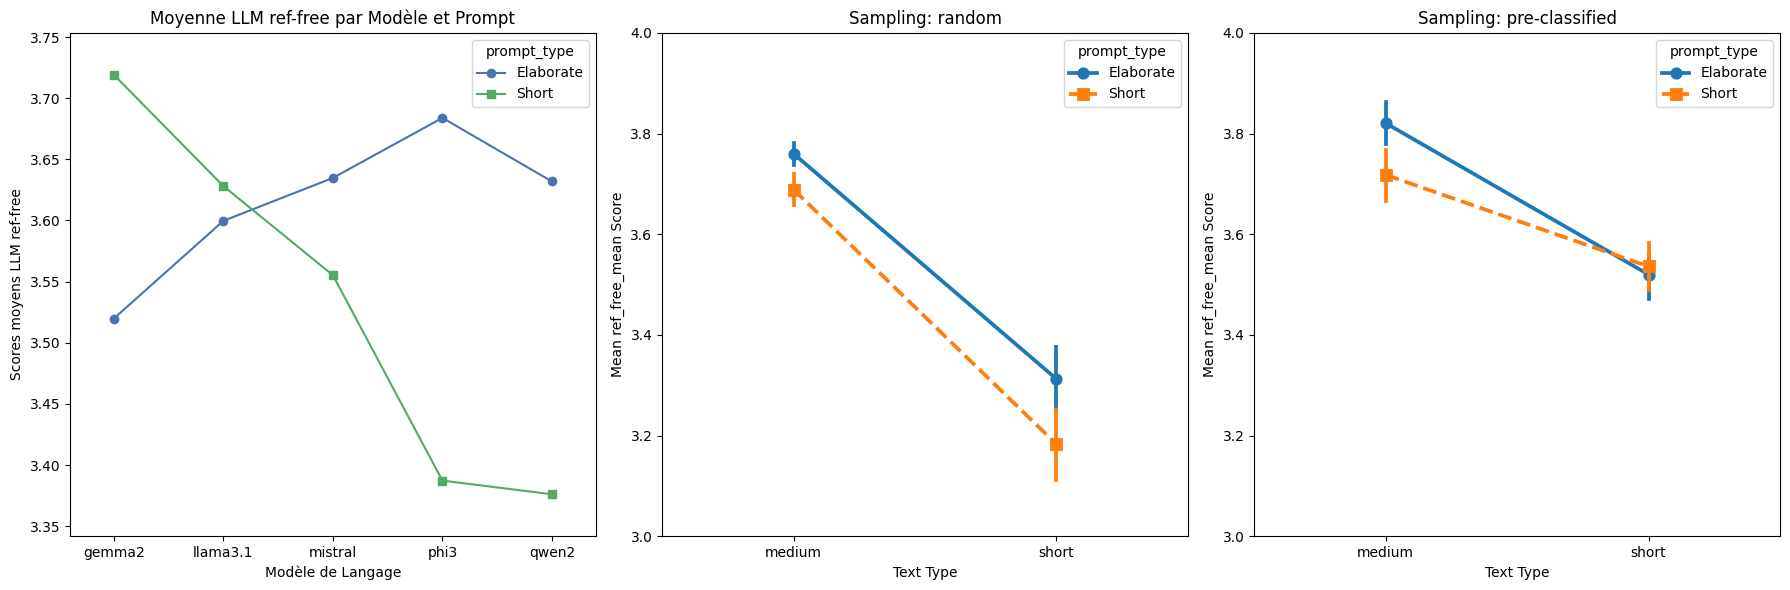

In [86]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns

# Create a subplot with three plots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Interaction plot: Model Name vs Prompt Type (1st plot)
interaction_plot(df['model_name'], df['prompt_type'], df['ref_free_mean'], 
                 markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("Moyenne LLM ref-free par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Scores moyens LLM ref-free')

# 2. Facet-like plot for 'sampling' == 'random' (2nd plot)
sns.pointplot(x='text_type', y='ref_free_mean', hue='prompt_type', data=df[df['sampling'] == 'random'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[1])
axes[1].set_title("Sampling: random")
axes[1].set_xlabel('Text Type')
axes[1].set_ylabel('Mean ref_free_mean Score')

# 3. Facet-like plot for 'sampling' == 'fixed' (3rd plot)
sns.pointplot(x='text_type', y='ref_free_mean', hue='prompt_type', data=df[df['sampling'] == 'pre-classified'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[2])
axes[2].set_title("Sampling: pre-classified")
axes[2].set_xlabel('Text Type')
axes[2].set_ylabel('Mean ref_free_mean Score')

# Set the same y-axis limits for both the center and right plots
y_min = 3
y_max = 4
axes[1].set_ylim(y_min, y_max)
axes[2].set_ylim(y_min, y_max)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

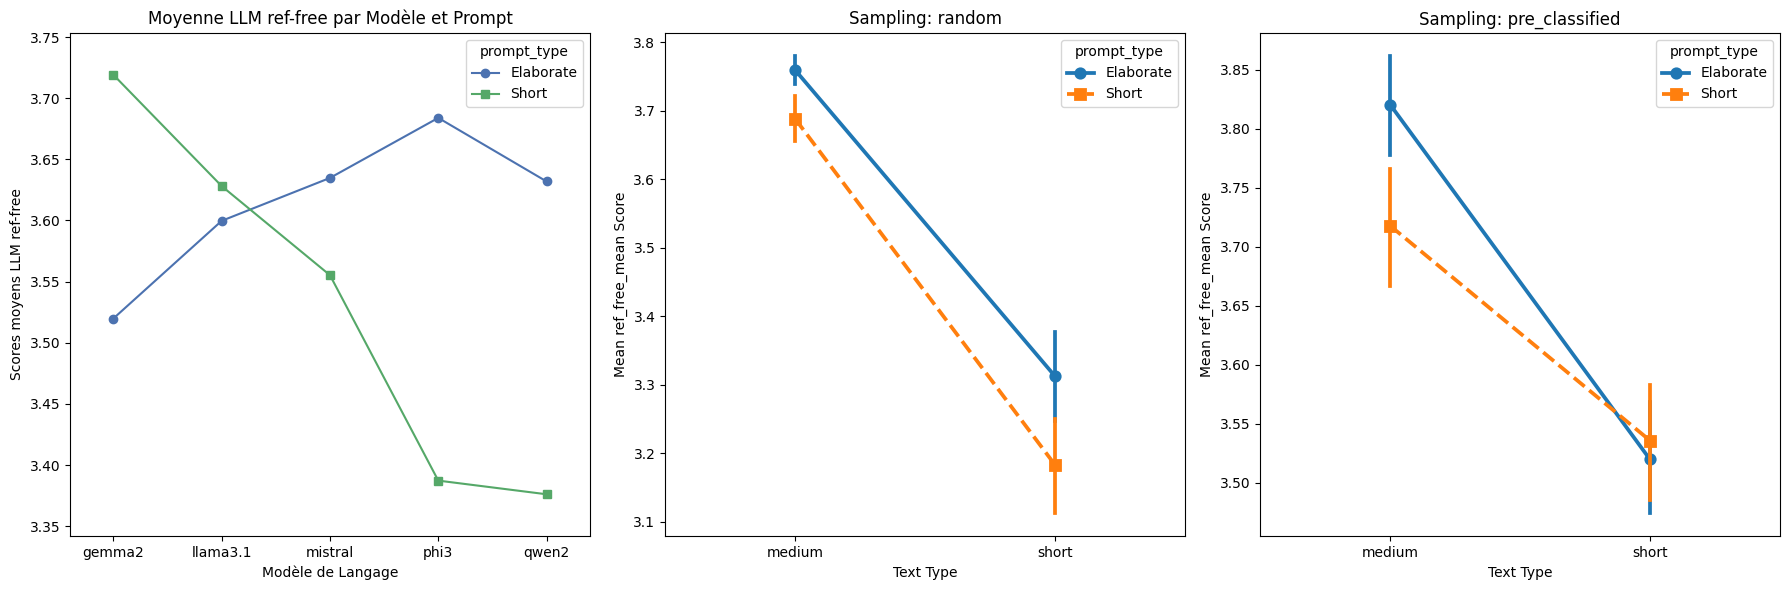

In [79]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns

# Create a subplot with three plots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Interaction plot: Model Name vs Prompt Type (1st plot)
interaction_plot(df['model_name'], df['prompt_type'], df['ref_free_mean'], 
                 markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("Moyenne LLM ref-free par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Scores moyens LLM ref-free')

# 2. Facet-like plot for 'sampling' == 'random' (2nd plot)
sns.pointplot(x='text_type', y='ref_free_mean', hue='prompt_type', data=df[df['sampling'] == 'random'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[1])
axes[1].set_title("Sampling: random")
axes[1].set_xlabel('Text Type')
axes[1].set_ylabel('Mean ref_free_mean Score')

# 3. Facet-like plot for 'sampling' == 'fixed' (3rd plot)
sns.pointplot(x='text_type', y='ref_free_mean', hue='prompt_type', data=df[df['sampling'] == 'pre-classified'], 
              markers=['o', 's'], linestyles=["-", "--"], ax=axes[2])
axes[2].set_title("Sampling: pre_classified")
axes[2].set_xlabel('Text Type')
axes[2].set_ylabel('Mean ref_free_mean Score')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

C:\Users\jeanv\AppData\Local\Temp\ipykernel_6444\2808375327.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model_name', y='ref_free_mean', data=df, palette="Set1", width=0.6, linewidth=2.5, ax=axs[0])


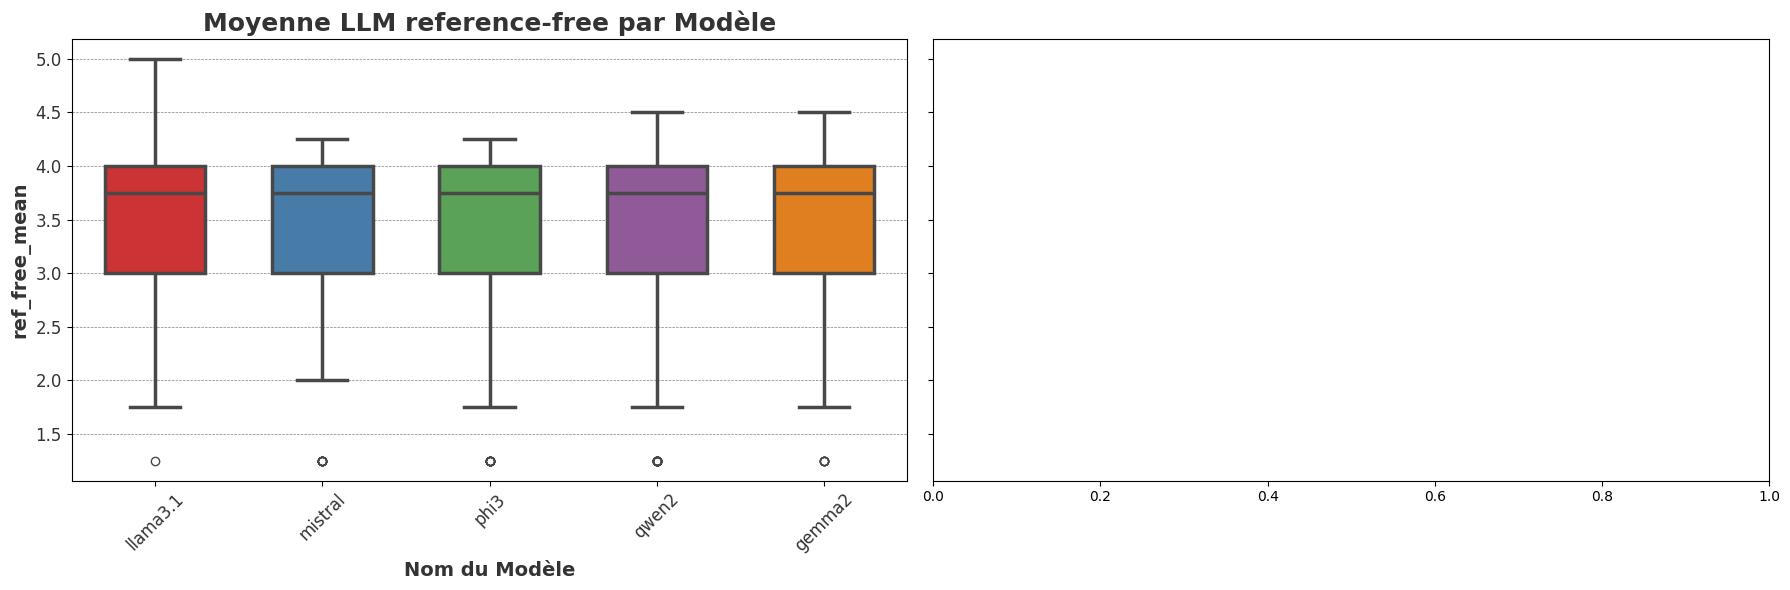

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the combined figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)


# Boxplot for 'prompt_type'
sns.boxplot(x='model_name', y='ref_free_mean', data=df, palette="Set1", width=0.6, linewidth=2.5, ax=axs[0])
axs[0].set_title("Moyenne LLM reference-free par Modèle", fontsize=18, fontweight='bold', color='#333')
axs[0].set_xlabel("Nom du Modèle", fontsize=14, fontweight='bold', color='#333')
axs[0].set_ylabel("ref_free_mean", fontsize=14, fontweight='bold', color='#333')
axs[0].tick_params(axis='x', labelsize=12, labelrotation=45, labelcolor='#333')
axs[0].tick_params(axis='y', labelsize=12, labelcolor='#333')
axs[0].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', axis='y')

# Adjust layout to avoid clipping
plt.tight_layout()
plt.show()

**HÉTÉROGÉNÉITÉ**

Mann-Whitney U test for rouge2 (sampling): MannwhitneyuResult(statistic=1402911.5, pvalue=7.271698650295682e-05)


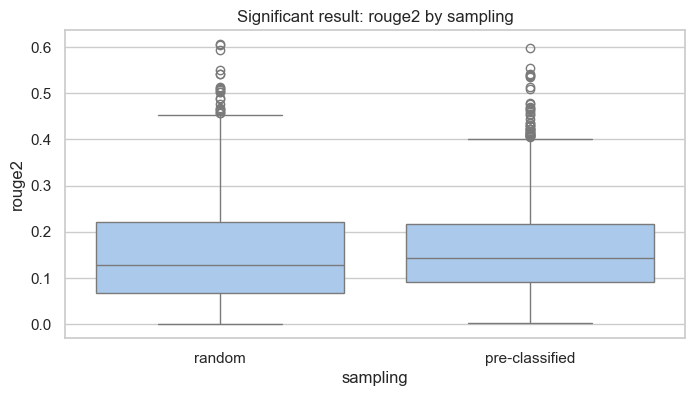

Mann-Whitney U test for rougeL (sampling): MannwhitneyuResult(statistic=1460014.0, pvalue=0.0402314642284802)


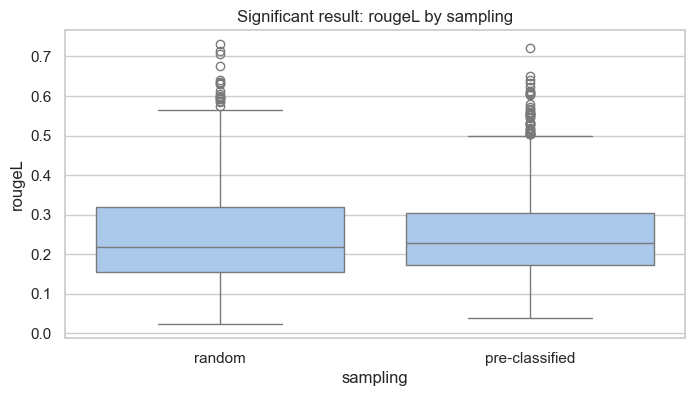

Mann-Whitney U test for bleu (sampling): MannwhitneyuResult(statistic=1443334.0, pvalue=0.009027880631252469)


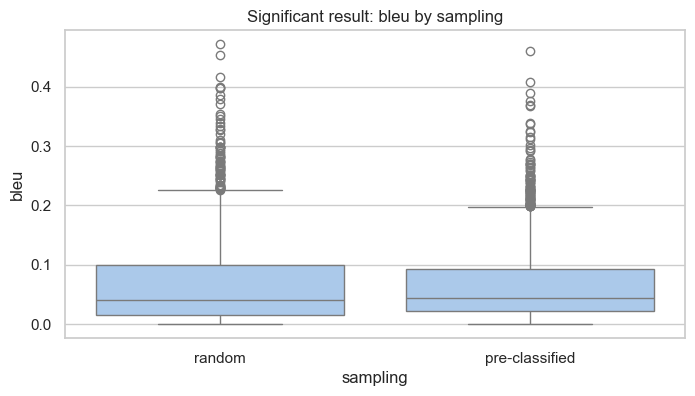

Mann-Whitney U test for cosine (sampling): MannwhitneyuResult(statistic=1319394.0, pvalue=4.4196568953108164e-57)


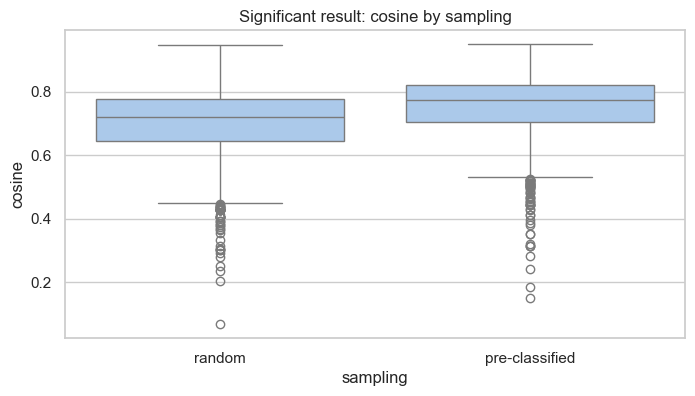

Mann-Whitney U test for flesch_reading (sampling): MannwhitneyuResult(statistic=1372674.0, pvalue=6.301973958461194e-07)


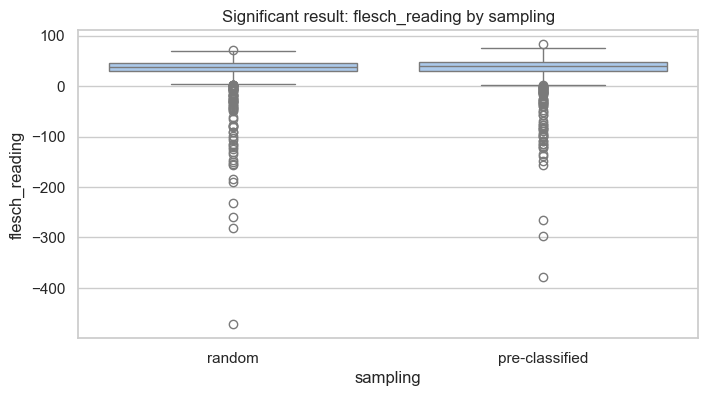

Mann-Whitney U test for dale_chall (sampling): MannwhitneyuResult(statistic=1860604.0, pvalue=4.7497317124500965e-30)


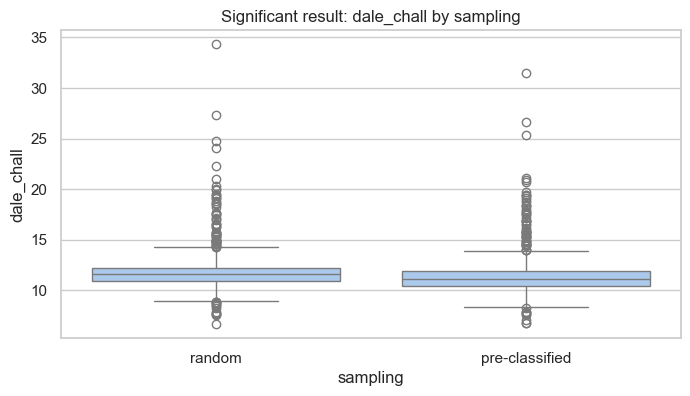

Mann-Whitney U test for accuracy_ref (sampling): MannwhitneyuResult(statistic=1787122.0, pvalue=2.2380121959814074e-09)


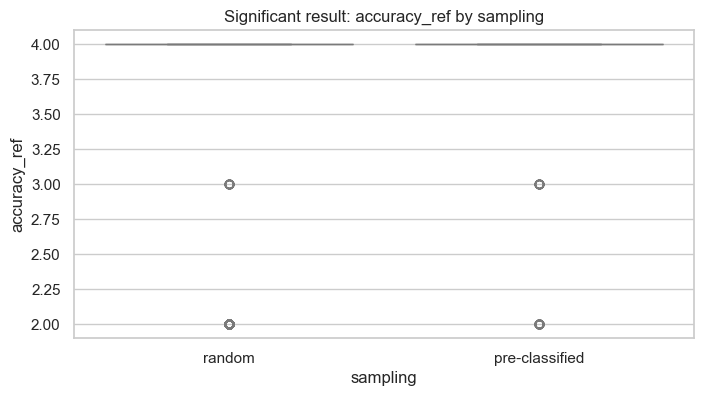

Mann-Whitney U test for conciseness_ref (sampling): MannwhitneyuResult(statistic=1811954.0, pvalue=2.4947407807331036e-05)


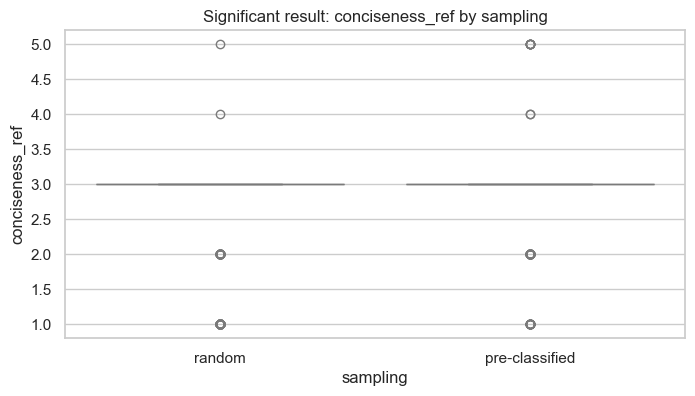

Mann-Whitney U test for structure_ref (sampling): MannwhitneyuResult(statistic=1836906.5, pvalue=0.15564641568533022)
Mann-Whitney U test for ref_based_mean (sampling): MannwhitneyuResult(statistic=1866076.0, pvalue=0.8268775315029305)
Mann-Whitney U test for clarity_free (sampling): MannwhitneyuResult(statistic=1715085.0, pvalue=8.536839057777418e-29)


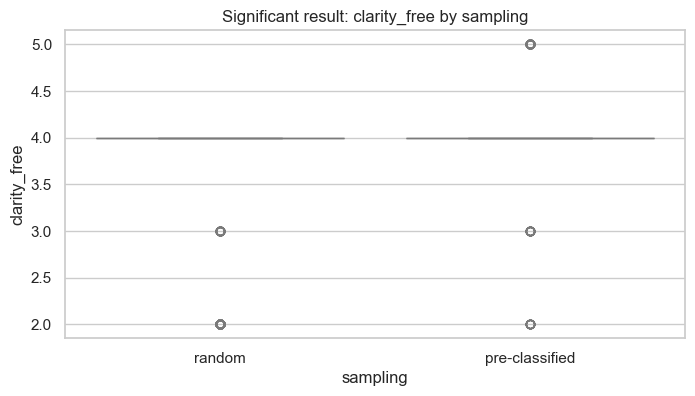

Mann-Whitney U test for accuracy_free (sampling): MannwhitneyuResult(statistic=1974077.0, pvalue=0.0002578248774099108)


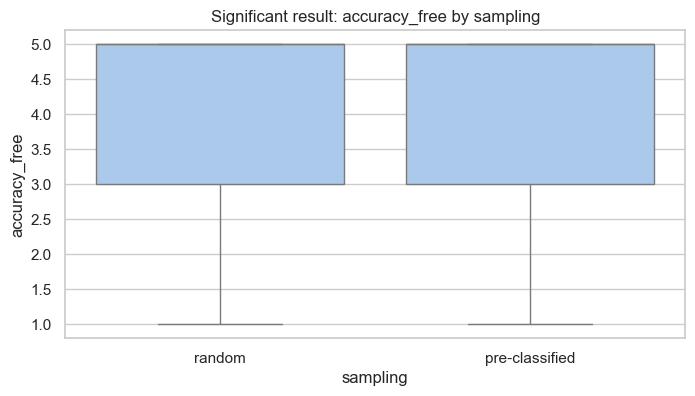

Mann-Whitney U test for coverage_free (sampling): MannwhitneyuResult(statistic=1673760.5, pvalue=1.0215971715550308e-10)


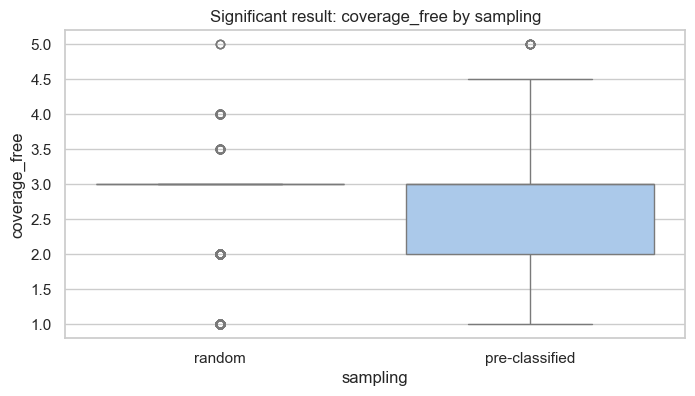

Mann-Whitney U test for quality_free (sampling): MannwhitneyuResult(statistic=1272495.0, pvalue=1.6048850511319706e-96)


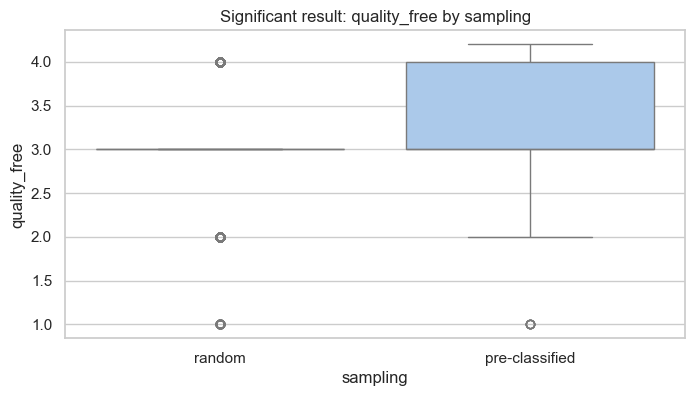

Mann-Whitney U test for ref_free_mean (sampling): MannwhitneyuResult(statistic=1474563.5, pvalue=2.163503328288306e-33)


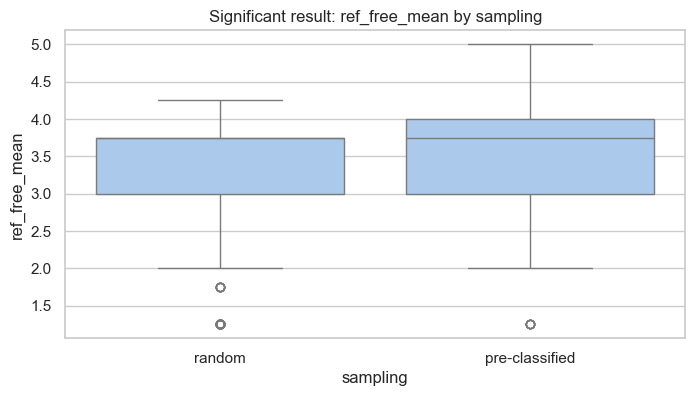

In [205]:

from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# List of dependent variables
dependent_vars = ['rouge2', 'rougeL', 'bleu', 'cosine', 'flesch_reading', 'dale_chall', 'accuracy_ref',
                  'conciseness_ref', 'structure_ref', 'ref_based_mean', 'clarity_free', 'accuracy_free',
                  'coverage_free', 'quality_free', 'ref_free_mean']

# Mann-Whitney U test for 'sampling'
for var in dependent_vars:
    # Drop rows with NaN values for the dependent variable
    df_clean = df.dropna(subset=[var])
    
    # Check if there are at least two unique values in the 'sampling' variable
    if df_clean['sampling'].nunique() < 2:
        print(f"Skipping {var} (sampling) due to insufficient unique values")
        continue
    
    # Ensure there are at least two groups to compare
    unique_values = df_clean['sampling'].unique()
    if len(unique_values) < 2:
        print(f"Skipping {var} (sampling) due to insufficient groups")
        continue
    
    # Get data for the two groups
    group1 = df_clean[df_clean['sampling'] == unique_values[0]][var]
    group2 = df_clean[df_clean['sampling'] == unique_values[1]][var]
    
    # Check if both groups have data
    if len(group1) == 0 or len(group2) == 0:
        print(f"Skipping {var} (sampling) due to empty groups")
        continue
    
    # Perform Mann-Whitney U test
    result = mannwhitneyu(group1, group2)
    print(f"Mann-Whitney U test for {var} (sampling): {result}")

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']


# Calculate mean for each dependent variable grouped by 'model_name'
df_viz = df.groupby('sampling')[dependent_vars].mean().reset_index()

df_viz.to_csv('heterogeneity_meanscores.csv')

**TEXT TYPE**

In [209]:
# Mann-Whitney U test for 'text_type'
for var in dependent_vars:
    # Drop rows with NaN values for the dependent variable
    df_clean = df.dropna(subset=[var])
    
    # Check if there are at least two unique values in the 'text_type' variable
    if df_clean['text_type'].nunique() < 2:
        print(f"Skipping {var} (text_type) due to insufficient unique values")
        continue
    
    # Ensure there are at least two groups to compare
    unique_values = df_clean['text_type'].unique()
    if len(unique_values) < 2:
        print(f"Skipping {var} (text_type) due to insufficient groups")
        continue
    
    # Get data for the two groups
    group1 = df_clean[df_clean['text_type'] == unique_values[0]][var]
    group2 = df_clean[df_clean['text_type'] == unique_values[1]][var]
    
    # Check if both groups have data
    if len(group1) == 0 or len(group2) == 0:
        print(f"Skipping {var} (text_type) due to empty groups")
        continue
    
    # Perform Mann-Whitney U test
    result = mannwhitneyu(group1, group2)
    print(f"Mann-Whitney U test for {var} (text_type): {result}")
    

Mann-Whitney U test for rouge1 (text_type): MannwhitneyuResult(statistic=2271987.0, pvalue=3.739575448345856e-146)
Mann-Whitney U test for rouge2 (text_type): MannwhitneyuResult(statistic=2466032.0, pvalue=1.211539574697945e-228)
Mann-Whitney U test for rougeL (text_type): MannwhitneyuResult(statistic=2425701.5, pvalue=5.687200443222656e-210)
Mann-Whitney U test for bleu (text_type): MannwhitneyuResult(statistic=2432173.5, pvalue=6.495644860609055e-213)
Mann-Whitney U test for cosine (text_type): MannwhitneyuResult(statistic=2334855.0, pvalue=1.9593012757124556e-40)
Mann-Whitney U test for bert_score (text_type): MannwhitneyuResult(statistic=2749029.0, pvalue=1.963493166551641e-140)
Mann-Whitney U test for flesch_reading (text_type): MannwhitneyuResult(statistic=1623317.5, pvalue=0.00010193944343632062)
Mann-Whitney U test for dale_chall (text_type): MannwhitneyuResult(statistic=1784453.5, pvalue=1.2104246152424777e-20)
Mann-Whitney U test for accuracy_ref (text_type): MannwhitneyuResu

In [200]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']


# Calculate mean for each dependent variable grouped by 'model_name'
df_viz = df.groupby('text_type')[dependent_vars].mean().round(2).reset_index()

df_viz.to_csv('text_type_meanscores.csv')

**PROMPT**

In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dependent_vars = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'cosine', 'bert_score',
                  'flesch_reading', 'dale_chall', 'accuracy_ref', 'conciseness_ref', 'structure_ref', 'ref_based_mean',
                  'clarity_free', 'accuracy_free', 'coverage_free', 'quality_free', 'ref_free_mean']


# Calculate mean for each dependent variable grouped by 'model_name'
df_viz = df.groupby('prompt_type')[dependent_vars].mean().reset_index()

df_viz.to_csv('prompt_meanscores.csv')

In [215]:
# Mann-Whitney U test for 'prompt_type'
for var in dependent_vars:
    # Drop rows with NaN values for the dependent variable
    df_clean = df.dropna(subset=[var])
    
    # Check if there are at least two unique values in the 'prompt_type' variable
    if df_clean['prompt_type'].nunique() < 2:
        print(f"Skipping {var} (prompt_type) due to insufficient unique values")
        continue
    
    # Ensure there are at least two groups to compare
    unique_values = df_clean['prompt_type'].unique()
    if len(unique_values) < 2:
        print(f"Skipping {var} (prompt_type) due to insufficient groups")
        continue
    
    # Get data for the two groups
    group1 = df_clean[df_clean['prompt_type'] == unique_values[0]][var]
    group2 = df_clean[df_clean['prompt_type'] == unique_values[1]][var]
    
    # Check if both groups have data
    if len(group1) == 0 or len(group2) == 0:
        print(f"Skipping {var} (prompt_type) due to empty groups")
        continue
    
    # Perform Mann-Whitney U test
    result = mannwhitneyu(group1, group2)
    print(f"Mann-Whitney U test for {var} (prompt_type): {result}")

Mann-Whitney U test for rouge1 (prompt_type): MannwhitneyuResult(statistic=1585549.0, pvalue=0.08272981080577706)
Mann-Whitney U test for rouge2 (prompt_type): MannwhitneyuResult(statistic=1533496.5, pvalue=0.9966407396539646)
Mann-Whitney U test for rougeL (prompt_type): MannwhitneyuResult(statistic=1539016.5, pvalue=0.85699231761752)
Mann-Whitney U test for bleu (prompt_type): MannwhitneyuResult(statistic=1550819.0, pvalue=0.5655766580009671)
Mann-Whitney U test for cosine (prompt_type): MannwhitneyuResult(statistic=2026719.5, pvalue=9.25318596319711e-06)
Mann-Whitney U test for bert_score (prompt_type): MannwhitneyuResult(statistic=1892020.5, pvalue=0.5760893500590906)
Mann-Whitney U test for flesch_reading (prompt_type): MannwhitneyuResult(statistic=1571210.5, pvalue=0.20913373684493364)
Mann-Whitney U test for dale_chall (prompt_type): MannwhitneyuResult(statistic=1543271.0, pvalue=0.7471742501956585)
Mann-Whitney U test for accuracy_ref (prompt_type): MannwhitneyuResult(statistic

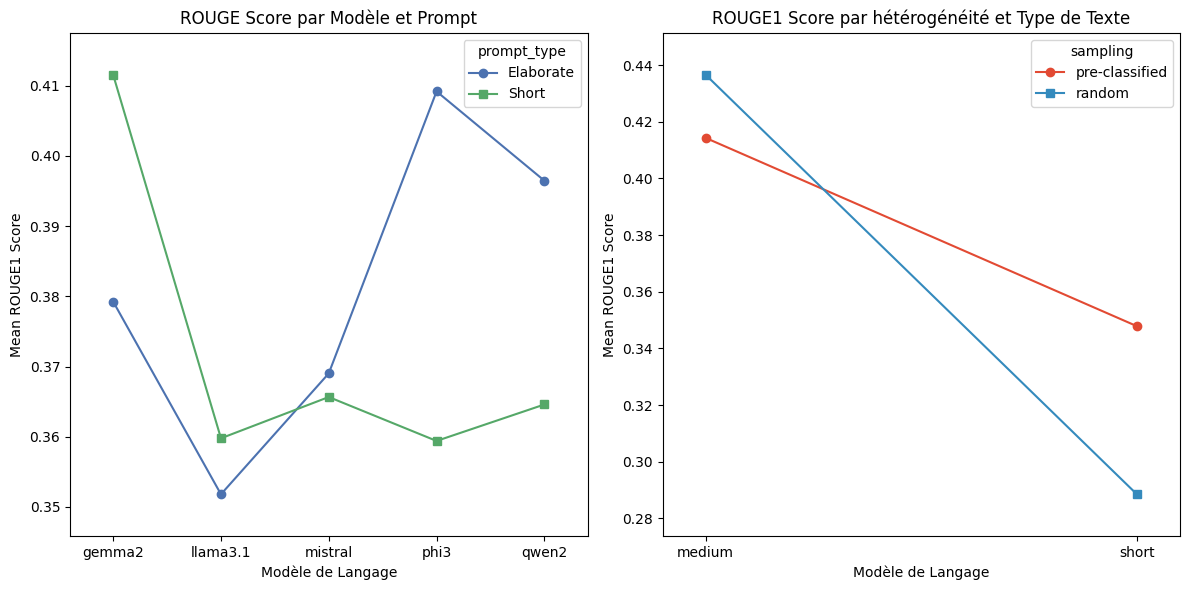

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

# Create a subplot with two figures side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Interaction plot: Model Name vs Prompt Type
interaction_plot(df['model_name'], df['prompt_type'], df['rouge1'], markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("ROUGE Score par Modèle et Prompt")
axes[0].set_xlabel('Modèle de Langage')
axes[0].set_ylabel('Mean ROUGE1 Score')

# Interaction plot: Model Name vs Text Type
interaction_plot(df['text_type'], df['sampling'], df['rouge1'], markers=['o', 's'], colors=['#e24a33', '#348abd'], ax=axes[1])
axes[1].set_title("ROUGE1 Score par hétérogénéité et Type de Texte")
axes[1].set_xlabel('Modèle de Langage')
axes[1].set_ylabel('Mean ROUGE1 Score')

# Adjust layout to make room for titles
plt.tight_layout()
plt.show()

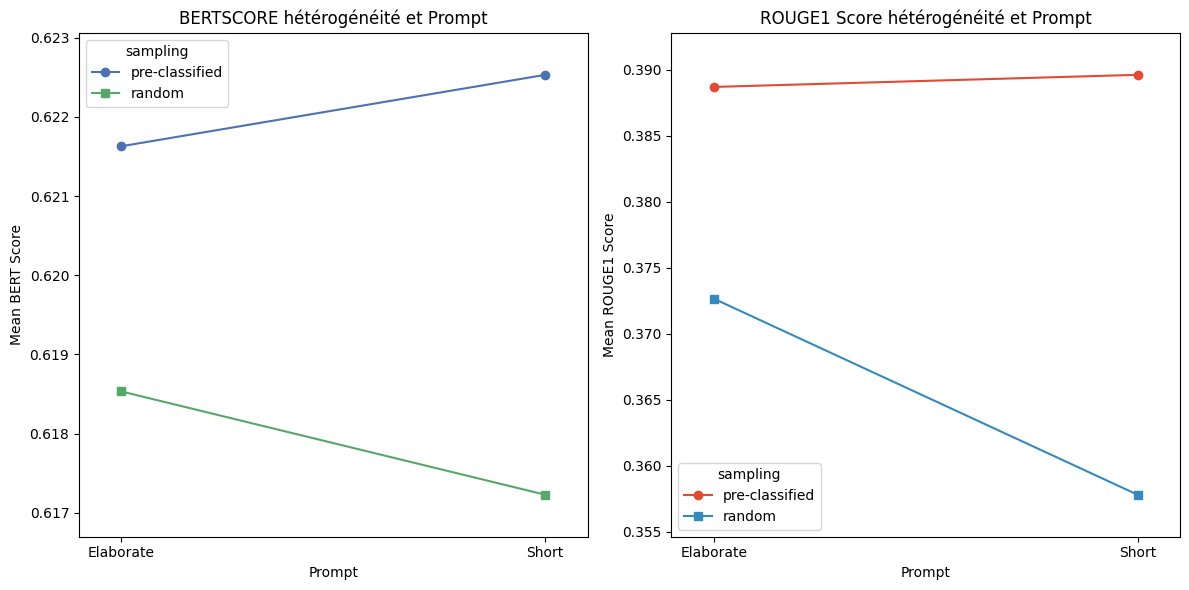

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

# Create a subplot with two figures side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Interaction plot: Model Name vs Prompt Type
interaction_plot(df['prompt_type'], df['sampling'], df['bert_score'], markers=['o', 's'], colors=['#4c72b0', '#55a868'], ax=axes[0])
axes[0].set_title("BERTSCORE hétérogénéité et Prompt")
axes[0].set_xlabel('Prompt')
axes[0].set_ylabel('Mean BERT Score')

# Interaction plot: Model Name vs Text Type
interaction_plot(df['prompt_type'], df['sampling'], df['rouge1'], markers=['o', 's'], colors=['#e24a33', '#348abd'], ax=axes[1])
axes[1].set_title("ROUGE1 Score hétérogénéité et Prompt")
axes[1].set_xlabel('Prompt')
axes[1].set_ylabel('Mean ROUGE1 Score')

# Adjust layout to make room for titles
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import statsmodels.stats.multicomp as mc

# Create interaction term as a combined factor
df['interaction'] = df['text_type'].astype(str) + '_' + df['sampling'].astype(str)

# Drop rows with NaN values in the dependent variable or interaction term
df_clean = df.dropna(subset=['rouge1', 'interaction'])

# Perform Tukey HSD on the interaction term
tukey_interaction = mc.pairwise_tukeyhsd(df_clean['rouge1'], df_clean['interaction'])
print(tukey_interaction)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
        group1               group2        meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------
medium_pre-classified        medium_random   0.0223 0.0001   0.009  0.0356   True
medium_pre-classified short_pre-classified  -0.0665    0.0 -0.0817 -0.0512   True
medium_pre-classified         short_random  -0.1258    0.0 -0.1393 -0.1123   True
        medium_random short_pre-classified  -0.0887    0.0  -0.104 -0.0735   True
        medium_random         short_random  -0.1481    0.0 -0.1616 -0.1346   True
 short_pre-classified         short_random  -0.0593    0.0 -0.0748 -0.0439   True
---------------------------------------------------------------------------------
